In [1]:
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading necessary libraries to build and train model                       │
└──────────────────────────────────────────────────────────────────────────"""
import os,sys,gc
import numpy as np
import pickle
import torch
import proplot as plot
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/scikit/')
from tools import derive_var,read_and_proc
from tools.mlr import mlr
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
from tools.validation import r2_analysis
sys.path.insert(2, '../')
import read_stuff as read
import analysis_models as analysis
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_462120/173461075.py:22: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
sys.path.insert(3, '../parallel/')

In [1]:
?? read_and_proc.depickle

Object ` read_and_proc.depickle` not found.


In [10]:
from linear_models import OptimMLR_all_3D_simple_lwswu

In [7]:
from tqdm.auto import tqdm
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
import os,glob
from natsort import natsorted
def flatten(l):
    return [item for sublist in l for item in sublist]

def read_bestloss(nonlnnum=None):
    modelpaths = natsorted(glob.glob('../tmp/torch_try/pytorch_3d_nonlinear/'+str(nonlnnum)+'/loss*'))
    train = [read_and_proc.depickle(obj)[0]['train'] for obj in modelpaths]
    val = [read_and_proc.depickle(obj)[0]['val'] for obj in modelpaths]
    besttrain,bestval = np.asarray([obj[-1] for obj in train]).argmin(),np.asarray([obj[-1] for obj in val]).argmin()
    return {'train':train[besttrain],'val':val[besttrain],'label':besttrain},{'train':train[bestval],'val':val[bestval],'label':bestval},{'train':train,'val':val}

# Loss

In [56]:
besttrains,bestvals,allmodels = [],[],[]
for i in range(1,14):
    besttrain,bestval,allmodel = read_bestloss(i)
    besttrains.append(besttrain)
    bestvals.append(bestval)
    allmodels.append(allmodel)

In [81]:
trainlasts,valslasts = [],[]
for ind,obj in enumerate(allmodels):
    trains,vals = obj['train'],obj['val']
    trainlast = [trobj[-1] for trobj in trains]
    valslast  = [vlobj[-1] for vlobj in vals]
    trainlasts.append(trainlast)
    valslasts.append(valslast)

In [99]:
def read_linearloss(splitnum=None):
    modelpaths = natsorted(glob.glob('../tmp/torch_try/1115_3d/'+str(splitnum)+'/loss*'))
    train = [read_and_proc.depickle(obj)[0]['train'][-1] for obj in modelpaths]
    val = [read_and_proc.depickle(obj)[0]['val'][-1] for obj in modelpaths]
    return {'train':train,'val':val}

linear_train,linear_val = [],[]
for i in range(33):
    temp = read_linearloss(splitnum=i)
    linear_train.append(temp['train'])
    linear_val.append(temp['val'])

/tmp/ipykernel_1073336/2406090083.py:3: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


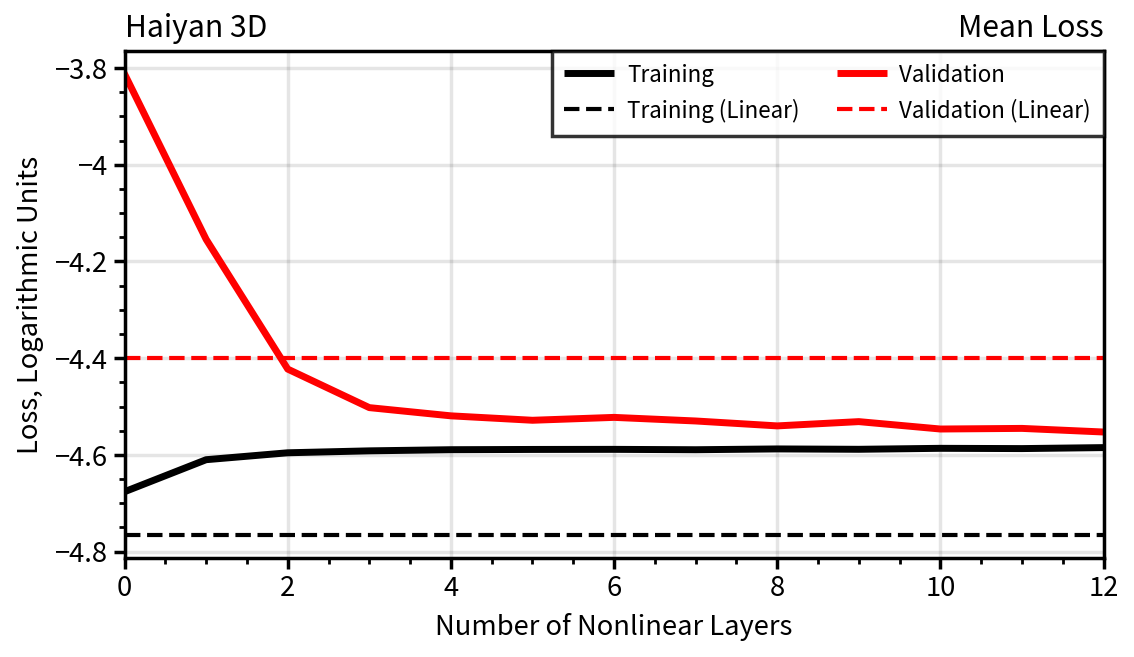

In [121]:
colos = ['r','b','k','yellow','m','g','royalblue']
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig, ax1 = plot.subplots(ncols=1,nrows=1,axwidth=4.895,refaspect=1.931,share=False)
#for ind,allmodel in enumerate(allmodels[0:7]):
#    for model in allmodel['val']:
#        ax1.plot(np.log10(model),c=colos[ind],lw=0.5,alpha=0.5,ls='--')
ax1.plot([np.log10(np.mean(obj)) for obj in trainlasts],lw=2.5,c='k',label='Training')
ax1.plot([np.log10(np.mean(obj)) for obj in valslasts],lw=2.5,c='r',label='Validation')
ax1.axhline(y=np.log10(np.mean(np.asarray(flatten(linear_train)))),lw=1.5,ls='--',c='k',label='Training (Linear)')
ax1.axhline(y=np.log10(np.mean(np.asarray(flatten(linear_val)))),lw=1.5,ls='--',c='r',label='Validation (Linear)')
ax1.legend(loc=1,ncols=2,prop={'size':9})
ax1.format(ylabel='Loss, Logarithmic Units', xlabel='Number of Nonlinear Layers',ltitle='Haiyan 3D',rtitle='Mean Loss')
plt.savefig('./pic/1228/haiyan3d_loss_nonlinear.png',dpi=300)
plt.show()

# Performance Ranking

In [4]:
class OptimMLR_all_3D_simple(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [20,20]#[50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        #self.dense3 = torch.nn.Linear(brchsize[2], 1)
        #self.dense4 = torch.nn.Linear(brchsize[3], 1)
        #self.dense5 = torch.nn.Linear(brchsize[4], 1)
        #self.dense6 = torch.nn.Linear(brchsize[5], 1)
        #self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(2,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestlw = self.dense1(X_lw)
        bestsw = self.dense2(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

In [5]:
class OptimMLR_all_3D(torch.nn.Module):
    def __init__(self,num_nonlinear):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        ############################################################
        # Nonlinear layers
        ############################################################
        self.nonln = torch.nn.ModuleList([
            torch.nn.Sequential(torch.nn.Linear(2,2),
                                torch.nn.LeakyReLU()) for i in range(num_nonlinear)])
                                
        #for i in range(num_nonlinear):
        #    self.nonln.append(torch.nn.Linear(7,7))
        #    self.nonln.append(torch.nn.LeakyReLU())
        #self.nonln = torch.nn.
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(2,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestlw = self.dense1(X_lw)
        bestsw = self.dense2(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestlw,bestsw),1)
        bestPC_proc = bestPC
        ############################################################
        # Nonlinear layer
        ############################################################
        for nonln in self.nonln:
            bestPC_proc = nonln(bestPC_proc)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC_proc)
        return outpred

#### all channels

In [4]:
from tools.validation import r2_analysis
class OptimMLR_all_3D_simple(torch.nn.Module):
    def __init__(self):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D_simple, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(7,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        besthdia = self.dense5(X_hdia)
        bestlw = self.dense6(X_lw)
        bestsw = self.dense7(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,besthdia,bestlw,bestsw),1)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC)
        return outpred

In [5]:
class OptimMLR_all_3D(torch.nn.Module):
    def __init__(self,num_nonlinear):
        #super(OptimMLR_all_2D, self).__init__()
        super(OptimMLR_all_3D, self).__init__()
        ############################################################
        # Input channels
        ############################################################
        brchsize = [50,38,91,8,82,20,20]
        self.dense1 = torch.nn.Linear(brchsize[0], 1)
        self.dense2 = torch.nn.Linear(brchsize[1], 1)
        self.dense3 = torch.nn.Linear(brchsize[2], 1)
        self.dense4 = torch.nn.Linear(brchsize[3], 1)
        self.dense5 = torch.nn.Linear(brchsize[4], 1)
        self.dense6 = torch.nn.Linear(brchsize[5], 1)
        self.dense7 = torch.nn.Linear(brchsize[6], 1)
        ############################################################
        # Nonlinear layers
        ############################################################
        self.nonln = torch.nn.ModuleList([
            torch.nn.Sequential(torch.nn.Linear(7,7),
                                torch.nn.LeakyReLU()) for i in range(num_nonlinear)])
                                
        #for i in range(num_nonlinear):
        #    self.nonln.append(torch.nn.Linear(7,7))
        #    self.nonln.append(torch.nn.LeakyReLU())
        #self.nonln = torch.nn.
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(7,96)#106)
        
    def forward(self,X):
        brchindex = list(np.asarray([0,50,38,91,8,82,20,20]).cumsum())
        X_u, X_v, X_w, X_th = X[:,brchindex[0]:brchindex[1]],X[:,brchindex[1]:brchindex[2]],X[:,brchindex[2]:brchindex[3]],X[:,brchindex[3]:brchindex[4]]
        X_hdia, X_lw, X_sw = X[:,brchindex[4]:brchindex[5]],X[:,brchindex[5]:brchindex[6]],X[:,brchindex[6]:brchindex[7]]
        ############################################################
        # Optimal PC layer
        ############################################################
        bestu = self.dense1(X_u)
        bestv = self.dense2(X_v)
        bestw = self.dense3(X_w)
        bestth = self.dense4(X_th)
        besthdia = self.dense5(X_hdia)
        bestlw = self.dense6(X_lw)
        bestsw = self.dense7(X_sw)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat((bestu,bestv,bestw,bestth,besthdia,bestlw,bestsw),1)
        bestPC_proc = bestPC
        ############################################################
        # Nonlinear layer
        ############################################################
        for nonln in self.nonln:
            bestPC_proc = nonln(bestPC_proc)
        ############################################################
        # Prediction layer
        ############################################################
        outpred = self.denseout(bestPC_proc)
        return outpred

In [6]:
from tools.validation import r2_analysis
class train_optimizedMLR:
    def __init__(self,folderpath=None,modelpath=None,subfoldername=None,ysubfoldername='rh',twoDthreeD='2D' or '3D'):
        self.pcapath=folderpath
        self.modelpath=modelpath
        if twoDthreeD=='2D':
            self.pcastore = read_and_proc.depickle(self.pcapath+'PCAdict2D.pkg')
            self.flatarray = read_and_proc.depickle(self.pcapath+'flatarrays2D.pkg')
        elif twoDthreeD=='3D':
            self.pcastore = read_and_proc.depickle(self.pcapath+'PCAdict3D.pkg')
            self.flatarray = read_and_proc.depickle(self.pcapath+'flatarrays3D.pkg')            
        self.subfoldername=subfoldername
        self.ysubfoldername=ysubfoldername
        
    def read_Xy(self,num=33,needorig='No'):
        """
        Read in the processed PC loading time series
        """
        Xtest,Xtrain,Xvalid = [],[],[]
        yall = []
        for i in tqdm(range(num)):
            temp1,temp2,temp3,temp4 = real_random(self.modelpath,i,self.subfoldername,'keras',self.ysubfoldername)
            Xtest.append(temp1)
            Xtrain.append(temp2)
            Xvalid.append(temp3)
            yall.append(temp4)
        
        if needorig=='Yes':
            self.subfoldername=3
            yall_orig = []
            for i in tqdm(range(num)):
                temp1,temp2,temp3,temp4 = real_random(self.modelpath,i,self.subfoldername,'orig')
                yall_orig.append(temp4)
            return Xtrain,Xvalid,Xtest,yall,yall_orig
        else:
            return Xtrain,Xvalid,Xtest,yall
    
    def delete_padding(self,inTS=None,outTS=None):
        output_nozero,input_nozero = [],[]
        for i in range(len(outTS[:,0])):
            temp = outTS[i,:]
            tempin = inTS[i,:]
            if temp.all()==0:
                continue
            else:
                output_nozero.append(temp)
                input_nozero.append(tempin)
        return input_nozero,output_nozero
        
    def y_truth(self,divider=None,lti=24,num=33,withW=True):
        if withW is True:
            temp = [r2_analysis.preproc_r2(self.flatarray,None,None)._back_to_exp(timeseries=self.flatarray[varname],divider=divider) for varname in ['u','v','w','theta']]
        else:
            temp = [r2_analysis.preproc_r2(self.flatarray,None,None)._back_to_exp(timeseries=self.flatarray[varname],divider=divider) for varname in ['u','v','theta']]
        train_realUV,valid_realUV,test_realUV = [],[],[]
        for i in tqdm(range(num)):#range(15)):#range(1)):
            try:
                tempindex = _get_exp_name(self.modelpath,i,3,'orig')[1]
            except:
                tempindex = _get_exp_name('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/',i,3,'orig')[1]                
            validindex,testindex = [int(tempindex[0]),int(tempindex[1])],[int(tempindex[2]),int(tempindex[3])]
            trainobj = r2_analysis.preproc_r2(self.flatarray,validindex,testindex).windrates_real(uvwheat=temp,LT=lti,category='train',withW=withW)
            validobj = r2_analysis.preproc_r2(self.flatarray,validindex,testindex).windrates_real(uvwheat=temp,LT=lti,category='valid',withW=withW)
            testobj = r2_analysis.preproc_r2(self.flatarray,validindex,testindex).windrates_real(uvwheat=temp,LT=lti,category='test',withW=withW)
            train_realUV.append(trainobj)
            valid_realUV.append(validobj)
            test_realUV.append(testobj)
        del trainobj,validobj,testobj
        gc.collect()
        return {'train':train_realUV,'valid':valid_realUV,'test':test_realUV}

## Read stuff

In [5]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading input and outpus                    
└──────────────────────────────────────────────────────────────────────────"""
#Xtrain,Xvalid,Xtest,yall,yall_orig = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').read_Xy(num=33,needorig=False)
Xtrain,Xvalid,Xtest,yall = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').read_Xy(num=33,needorig='No')
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading PC structures for custom loss                       
└──────────────────────────────────────────────────────────────────────────"""
pcastore = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').pcastore
haiyan_data = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').flatarray
#wcomps = [26,18,48,14]
#upcs,vpcs,wpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['w'].components_[:wcomps[2]],pcastore['theta'].components_[:wcomps[3]]
wcomps = [50,38,8]
upcs,vpcs,thpcs = pcastore['u'].components_[:wcomps[0]],pcastore['v'].components_[:wcomps[1]],pcastore['theta'].components_[:wcomps[2]]
"""──────────────────────────────────────────────────────────────────────────┐
│ Loading y truth for custom loss                      
└──────────────────────────────────────────────────────────────────────────"""
#yTRUTH = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').y_truth(divider=divider,lti=24,num=33,withW=False)

  0%|          | 0/33 [00:00<?, ?it/s]

'──────────────────────────────────────────────────────────────────────────┐\n│ Loading y truth for custom loss                      \n└──────────────────────────────────────────────────────────────────────────'

In [12]:
import glob
def output_trainedmodels(path=None,splitnum=None,linear='Yes',nonlnnum=None):
    if linear=='Yes':
        modelpaths = sorted(glob.glob('../tmp/torch_try/1115_3d/'+str(splitnum)+'/models*'))
        model = [torch.load(obj) for obj in modelpaths]
    elif linear=='No':
        modelpaths = sorted(glob.glob('../tmp/torch_try/pytorch_3d_nonlinear/'+str(nonlnnum)+'/models'+str(splitnum)+'_'+'*'))
        model = [torch.load(obj) for obj in modelpaths]        
    return model

def output_trainedmodels_ffs(path=None,splitnum=None,nonlnnum=None):
    modelpaths = sorted(glob.glob(path+str(nonlnnum)+'/models'+str(splitnum)+'_'+'*'))
    model = [torch.load(obj) for obj in modelpaths]        
    return model

def output_pretrained_data(Xtrain=None,Xvalid=None,Xtest=None,yall=None,folderpath=None,folderpath2=None,splitnum=None,exp='lwswdtthuvw'):
    """──────────────────────────────────────────────────────────────────────────┐
    │ Which split will we be testing                     
    └──────────────────────────────────────────────────────────────────────────"""
    splitnum = splitnum
    """──────────────────────────────────────────────────────────────────────────┐
    │ Remove zero values                    
    └──────────────────────────────────────────────────────────────────────────"""
    X_totrain,y_totrain = read.train_optimizedMLR(folderpath,folderpath2,'rh','3D').delete_padding(Xtrain[splitnum][exp],yall[splitnum][23][0])
    X_tovalid,y_tovalid = read.train_optimizedMLR(folderpath,folderpath2,'rh','3D').delete_padding(Xvalid[splitnum][exp],yall[splitnum][23][1])
    X_totest,y_totest = read.train_optimizedMLR(folderpath,folderpath2,'rh','3D').delete_padding(Xtest[splitnum][exp],yall[splitnum][23][2])
    
    calc_device = 'cpu'
    ###################################################################################
    # Convert numpy arrays into tensors
    ###################################################################################
    train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)
    train_ytensor = torch.FloatTensor(y_totrain).to(calc_device)
    val_Xtensor = torch.FloatTensor(X_tovalid).to(calc_device)
    val_ytensor = torch.FloatTensor(y_tovalid).to(calc_device)
    test_Xtensor = torch.FloatTensor(X_totest).to(calc_device)
    test_ytensor = torch.FloatTensor(y_totest).to(calc_device)
    train_data = torch.utils.data.TensorDataset(train_Xtensor, train_ytensor)
    val_data = torch.utils.data.TensorDataset(val_Xtensor, val_ytensor)
    test_data = torch.utils.data.TensorDataset(test_Xtensor, test_ytensor)
    return {'train':train_Xtensor,'val':val_Xtensor,'test':test_Xtensor},{'train':train_ytensor,'val':val_ytensor,'test':test_ytensor},{'train':train_data,'val':val_data,'test':test_data}

## Analysis

In [13]:
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from sklearn.metrics import r2_score
class analysis_trainedmodels:
    def __init__(self,folderpath=None,folderpath2=None,pcastore=None,divider=None,comps=None,Xtrain=None,Xvalid=None,Xtest=None,yall=None,linear='No' or 'Yes',nonlnnum=None):
        self.folderpath=folderpath
        self.folderpath2=folderpath2
        self.pcastore = pcastore
        self.divider = divider
        self.comps = comps
        self.Xtrain = Xtrain
        self.Xvalid = Xvalid
        self.Xtest = Xtest
        self.yall = yall
        self.linear = linear
        self.nonlnnum=nonlnnum
        
    def _get_ytruth(self,splitnum=None,leadtime=24):
        return read.train_optimizedMLR(self.folderpath,self.folderpath2,'rhorig','rhorig','3D').y_truth(divider=self.divider,lti=leadtime,num=33,withW=False,splitnum=[splitnum])
    
    def _get_tensors(self,splitnum=None,exp='lwswdtthuvw'):
        return output_pretrained_data(self.Xtrain,self.Xvalid,self.Xtest,self.yall,self.folderpath,self.folderpath2,splitnum,exp)
    
    def get_4layers(self,flatarray=None,vertlvs=10,layerindices=[0,2,5,8]):
        largearray = flatarray.reshape(flatarray.shape[0],vertlvs,360,int(flatarray.shape[1]/vertlvs/360))
        output = [largearray[:,i,...] for i in layerindices]
        del largearray
        gc.collect()
        return output
    
    def get_modelpred(self,splitnum=None,predcat='test',exp='lwswdtthuvw'):
        models = output_trainedmodels(splitnum=splitnum,linear=self.linear,nonlnnum=self.nonlnnum)
        Xtensor,ytensor,data = output_pretrained_data(self.Xtrain,self.Xvalid,self.Xtest,self.yall,self.folderpath,self.folderpath2,splitnum,exp)#output_processed(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,split,linear,nonlnnum)
        predstore = []
        modelstore = []
        for i in range(len(models)):
            predstore.append(models[i][0](Xtensor[predcat]).detach().numpy())
            modelstore.append(models[i])
        return predstore,modelstore
    
    def get_modelpred_ffs(self,path=None,splitnum=None,predcat='test',exp='lwswdtthuvw'):
        models = output_trainedmodels_ffs(path=path,splitnum=splitnum,nonlnnum=self.nonlnnum)
        Xtensor,ytensor,data = output_pretrained_data(self.Xtrain,self.Xvalid,self.Xtest,self.yall,self.folderpath,self.folderpath2,splitnum,exp)#output_processed(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,split,linear,nonlnnum)
        predstore = []
        modelstore = []
        for i in range(len(models)):
            predstore.append(models[i][0](Xtensor[predcat]).detach().numpy())
            modelstore.append(models[i])
        return predstore,modelstore
    
    def get_pd_preds(self,model=None,alt_Xtensor=None):
        return models[0](alt_Xtensor[predcat]).detach().numpy()
    
    def onepred_to_4d(self,pred=None,target='4layers' or 'all'):
        u = np.dot(pred[:,:self.comps[0]],self.pcastore['u'].components_[:self.comps[0]])
        v = np.dot(pred[:,self.comps[0]:self.comps[0]+self.comps[1]],self.pcastore['v'].components_[:self.comps[1]])
        th = np.dot(pred[:,self.comps[0]+self.comps[1]:self.comps[0]+self.comps[1]+self.comps[2]],self.pcastore['theta'].components_[:self.comps[2]])
        if target=='4layers':
            uout,vout,thout = self.get_4layers(u,10,[0,2,5,8]),self.get_4layers(v,10,[0,2,5,8]),self.get_4layers(th,10,[0,2,5,8])
        else:
            uout = u
            vout = v
            thout = th
        return {'u':uout,'v':vout,'th':thout}
    
    def pred_to_4d(self,pred=None,target='4layers' or 'all'):
        uout_store,vout_store,thout_store = [],[],[]
        for ind,obj in enumerate(pred):
            u = np.dot(obj[:,:self.comps[0]],self.pcastore['u'].components_[:self.comps[0]])
            v = np.dot(obj[:,self.comps[0]:self.comps[0]+self.comps[1]],self.pcastore['v'].components_[:self.comps[1]])
            th = np.dot(obj[:,self.comps[0]+self.comps[1]:self.comps[0]+self.comps[1]+self.comps[2]],self.pcastore['theta'].components_[:self.comps[2]])
            if target=='4layers':
                uout,vout,thout = self.get_4layers(u,10,[0,2,5,8]),self.get_4layers(v,10,[0,2,5,8]),self.get_4layers(th,10,[0,2,5,8])
            else:
                uout = u
                vout = v
                thout = th
            uout_store.append(uout)
            vout_store.append(vout)
            thout_store.append(thout)
            del u,v,th,uout,vout,thout
            gc.collect()
        return {'u':uout_store,'v':vout_store,'th':thout_store}
    
    def truth_to_4d(self,truth=None,target='4layers' or 'all',predcat='test'):
        utruth,vtruth,thtruth = truth[predcat][0]['du'],truth[predcat][0]['dv'],truth[predcat][0]['dth']
        if target=='4layers':
            return {'u':self.get_4layers(utruth,10,[0,2,5,8]), 'v':self.get_4layers(vtruth,10,[0,2,5,8]), 'th':self.get_4layers(thtruth,10,[0,2,5,8])}
        elif target=='all':
            return {'u':utruth,'v':vtruth,'th':thtruth}
    
    def _calc_ssmi(self,pred=None,truth=None,var='u',ANGLE=None):
        predVAR,truthVAR = pred[var],truth[var]
        modelsssim = []
        for ind in range(len(predVAR)): #models
            preds = predVAR[ind]
            ssimstore = []
            for layernum in range(len(preds)):
                predslayer,truthslayer = preds[layernum],truthVAR[layernum]
                #truthcart,predcart = [np.fliplr(np.flipud(read_and_proc.proc_tocart(truthslayer[i,...],ANGLE,True,False))) for i in (range(truthslayer.shape[0]))],\
                #[np.fliplr(np.flipud(read_and_proc.proc_tocart(predslayer[i,...],ANGLE,True,False))) for i in (range(truthslayer.shape[0]))]
                #ssimstore.append([ssim(truthcart[i],predcart[i],data_range=truthcart[i].max() - truthcart[i].min()) for i in (range(truthslayer.shape[0]))])
                #print(ssimstore)
                ssimstore.append([ssim(truthslayer[i,...],predslayer[i,...],data_range=truthslayer[i,...].max() - truthslayer[i,...].min()) for i in (range(truthslayer.shape[0]))])
            modelsssim.append(ssimstore)
        return modelsssim
            
    def calc_ssmi(self,predcat='test',ANGLES=None,exp='lwswdtthuvw'):
        ussim,vssim,thssim = [],[],[]
        for split in (range(33)):
            yTRUTH = self._get_ytruth(split,24)
            predstore,modelstore = self.get_modelpred(split,'test',exp)
            dict_4layers = self.pred_to_4d(predstore,'4layers')
            truth_4layers = self.truth_to_4d(yTRUTH,'4layers',predcat)
            del yTRUTH,predstore
            gc.collect()
            
            ussim.append(self._calc_ssmi(dict_4layers,truth_4layers,'u',ANGLES))
            vssim.append(self._calc_ssmi(dict_4layers,truth_4layers,'v',ANGLES))
            thssim.append(self._calc_ssmi(dict_4layers,truth_4layers,'th',ANGLES))
        return ussim,vssim,thssim
        #return None

    def _calc_r2(self,pred=None,truth=None,var='u',ANGLE=None):
        predVAR,truthVAR = pred[var],truth[var]
        modelr2 = []
        for ind in range(len(predVAR)): #models
            preds = predVAR[ind]
            modelr2.append(r2_score(truthVAR.transpose(),preds.transpose()))
        return modelr2
    
    def calc_r2(self,predcat='test',ANGLES=None,exp='lwswdtthuvw'):
        ur2,vr2,thr2 = [],[],[]
        for split in (range(33)):
            yTRUTH = self._get_ytruth(split,24)
            predstore,modelstore = self.get_modelpred(split,'test',exp)
            dict_all = self.pred_to_4d(predstore,'all')
            truth_all = self.truth_to_4d(yTRUTH,'all',predcat)
            del yTRUTH,predstore
            gc.collect()
            
            ur2.append(self._calc_r2(dict_all,truth_all,'u',ANGLES))
            vr2.append(self._calc_r2(dict_all,truth_all,'v',ANGLES))
            thr2.append(self._calc_r2(dict_all,truth_all,'th',ANGLES))
            del dict_all,truth_all
            gc.collect()
        return ur2,vr2,thr2

    def calc_r2_ffs(self,path=None,predcat='test',ANGLES=None,exp='lwswdtthuvw'):
        ur2,vr2,thr2 = [],[],[]
        for split in (range(33)):
            yTRUTH = self._get_ytruth(split,24)
            predstore,modelstore = self.get_modelpred_ffs(path,split,'test',exp)
            dict_all = self.pred_to_4d(predstore,'all')
            truth_all = self.truth_to_4d(yTRUTH,'all',predcat)
            del yTRUTH,predstore
            gc.collect()
            
            ur2.append(self._calc_r2(dict_all,truth_all,'u',ANGLES))
            vr2.append(self._calc_r2(dict_all,truth_all,'v',ANGLES))
            thr2.append(self._calc_r2(dict_all,truth_all,'th',ANGLES))
            del dict_all,truth_all
            gc.collect()
        return ur2,vr2,thr2
        
    def rank_choose_model(self,criteria='ssim',storeRESULTS=None,tokeep=None):
        if criteria=='ssim':
            storenonln = []
            for i in range(len(storeRESULTS)): #nonln
                ussim = storeRESULTS[i]
                storeperformance = []
                for j in range(len(ussim)): #model
                    storeperformance.append([(np.mean(obj1),np.mean(obj2),np.mean(obj3),np.mean(obj4)) for obj1,obj2,obj3,obj4 in (ussim[j])])
                storenonln.append(storeperformance)
            #print(len(storenonln[0][9]))
            del i,j
            
            numbers = np.asarray(storenonln)
            storenonln_ranked = np.zeros((numbers.shape[0],tokeep,2,numbers.shape[-1]))
            for i in range(numbers.shape[0]): #nonln
                for j in range(numbers.shape[-1]): #vertlayers
                    temp = list(zip(list(np.unravel_index(np.argsort(numbers[i,...,j],axis=None),numbers[i,...,j].shape))[0][-int(tokeep):],list(np.unravel_index(np.argsort(numbers[i,...,j],axis=None),numbers[i,...,j].shape))[1][-int(tokeep):]))
                    storenonln_ranked[i,...,j] = temp
            return storenonln_ranked
        
    def model_outweights(self,model=None):
        params,names = [],[]
        for name, param in model[0].named_parameters():
            if ".weight" not in name:
                continue
            else:
                params.append(param)
                names.append(name)
        return params, names

    def _where_exp_MLRpred(self,splitnum=None,exp_index=None,LT=24):
        orig = np.r_[self.divider[0], np.diff(self.divider)]
        getindex = [int(obj) for obj in read._get_exp_name('/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/',splitnum,3,'orig')[1]]
        
        if exp_index not in getindex:
            numexpout = sum([int(obj)<exp_index for obj in (getindex)])
            myindices = np.asarray([orig[i]-LT for i in range(len(orig)) if i not in getindex]).cumsum()
            if exp_index==0:
                return 0,myindices[exp_index-numexpout],myindices[exp_index-numexpout]-0,'train',getindex
            else:
                return myindices[exp_index-numexpout-1],myindices[exp_index-numexpout],myindices[exp_index-numexpout]-myindices[exp_index-numexpout-1],'train',getindex
        else:
            myidex = getindex.index(exp_index)
            if myidex<=1:
                category='valid'
                myindices = np.asarray([orig[i]-LT for i in range(len(orig)) if i in getindex[0:2]]).cumsum()
                if myidex==0:
                    return 0,myindices[0],myindices[0],category,getindex
                elif myidex==1:
                    return myindices[0],myindices[1],myindices[1]-myindices[0],category,getindex
            else:
                category='test'
                myindices = np.asarray([orig[i]-LT for i in range(len(orig)) if i in getindex[2:4]]).cumsum()
                if myidex==2:
                    return 0,myindices[0],myindices[0],category,getindex
                elif myidex==3:
                    return myindices[0],myindices[1],myindices[1]-myindices[0],category,getindex

    def where_exp_MLRpred(self,expnum=10,LT=24):
        start,end,exp,size,expname = [],[],[],[],[]
        for i in range(33):
            temp1,temp2,temp3,temp4,temp5 = self._where_exp_MLRpred(i,expnum,LT)
            start.append(temp1)
            end.append(temp2)
            exp.append(temp4)
            size.append(temp3)
            expname.append(temp5)
            #except:
            #    start.append(None)
            #    end.append(None)
            #    exp.append(None)
            #    size.append(None)
        return pd.DataFrame.from_dict({'start':start,'end':end,'exp':exp,'size':size,'splitinfo':expname})
    
    def get_multiple_r2(self,path=None,predcat='test',ANGLE=None,exp='lwswdtthuvw',totalsplit=None,modelsplit=None):
        # get models with one split
        models = [obj[0] for obj in self.get_modelpred_ffs(path,modelsplit,predcat,exp)[1]]
        # get preds
        ur2,vr2,thr2 = [],[],[]
        temp = []
        for ind,obj in enumerate(totalsplit):
            Xtensor = output_pretrained_data(self.Xtrain,self.Xvalid,self.Xtest,self.yall,self.folderpath,self.folderpath2,splitnum=obj,exp=exp)[0]
            modelpreds = [models[i](Xtensor[predcat]).detach().numpy() for i in range(len(models))]
            yTRUTH = self._get_ytruth(obj,24)
            dict_alls = self.pred_to_4d(modelpreds,'all')
            truth_all = self.truth_to_4d(yTRUTH,'all',predcat)
            del yTRUTH,modelpreds
            gc.collect()
            
            ur2.append(self._calc_r2(dict_alls,truth_all,'u',ANGLE))
            vr2.append(self._calc_r2(dict_alls,truth_all,'v',ANGLE))
            thr2.append(self._calc_r2(dict_alls,truth_all,'th',ANGLE))
            del dict_alls,truth_all
            gc.collect()
        return ur2,vr2,thr2
            
        
    def calc_r2_ffs(self,path=None,predcat='test',ANGLES=None,exp='lwswdtthuvw'):
        ur2,vr2,thr2 = [],[],[]
        for split in (range(33)):
            yTRUTH = self._get_ytruth(split,24)
            predstore,modelstore = self.get_modelpred_ffs(path,split,'test',exp)
            dict_all = self.pred_to_4d(predstore,'all')
            truth_all = self.truth_to_4d(yTRUTH,'all',predcat)
            del yTRUTH,predstore
            gc.collect()
            
            ur2.append(self._calc_r2(dict_all,truth_all,'u',ANGLES))
            vr2.append(self._calc_r2(dict_all,truth_all,'v',ANGLES))
            thr2.append(self._calc_r2(dict_all,truth_all,'th',ANGLES))
            del dict_all,truth_all
            gc.collect()
        return ur2,vr2,thr2        

In [13]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))

#storeUs,storeVs,storeTHs = [],[],[]
#for i in tqdm(range(0,1)):
#    ussim,vssim,thssim = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='No',nonlnnum=i).calc_ssmi('test',ANGLE,'lwswdtthuvw')
#    storeUs.append(ussim)
#    storeVs.append(vssim)
#    storeTHs.append(thssim)
ussim,vssim,thssim = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='Yes',nonlnnum=0).calc_ssmi('test',ANGLE,'lwswdtthuvw')

0it [00:00, ?it/s]

/tmp/ipykernel_304772/1559479888.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660136119739/work/torch/csrc/utils/tensor_new.cpp:201.)
  train_Xtensor = torch.FloatTensor(X_totrain).to(calc_device)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
read_and_proc.save_to_pickle('./3D/store/test/ln_U.test.ssim',ussim,'PICKLE')
read_and_proc.save_to_pickle('./3D/store/test/ln_V.test.ssim',vssim,'PICKLE')
read_and_proc.save_to_pickle('./3D/store/test/ln_TH.test.ssim',thssim,'PICKLE')

In [ ]:
from linear_models import OptimMLR_all_3D_simple_lwswu

In [15]:
#    def get_modelpred(self,splitnum=None,predcat='test',exp='lwswdtthuvw'):
#        models = output_trainedmodels(splitnum=splitnum,linear=self.linear,nonlnnum=self.nonlnnum)
#        Xtensor,ytensor,data = output_pretrained_data(self.Xtrain,self.Xvalid,self.Xtest,self.yall,self.folderpath,self.folderpath2,splitnum,exp)#output_processed(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,split,linear,nonlnnum)
#        predstore = []
#        modelstore = []
#        for i in range(len(models)):
#            predstore.append(models[i][0](Xtensor[predcat]).detach().numpy())
#            modelstore.append(models[i])
#        return predstore,modelstore

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
utmps,vtmps,thtmps = [],[],[]
for i in [0,1]:#range(33):
    utmp,vtmp,thtmp = analysis.analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],
                                   Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='Yes',nonlnnum=0).get_multiple_r2('../tmp/torch_try/lwswv/','test',ANGLE,'lwswdtthuvw',[int(obj) for obj in np.linspace(0,32,33)],i)
    #tmp = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],
    #                               Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='Yes',nonlnnum=0).get_multiple_r2('../tmp/torch_try/lwsw/','test',ANGLE,'lwswdtthuvw',[int(obj) for obj in np.linspace(8,10,3)],i)
    utmps.append(utmp)
    vtmps.append(vtmp)
    thtmps.append(thtmp)

0it [00:00, ?it/s]

ValueError: shapes (124,1) and (50,748800) not aligned: 1 (dim 1) != 50 (dim 0)

In [46]:
objssss = torch.load('../tmp/torch_try/lwswu/0/models0_')#lwswv/0/models5_lwswv3dnonln_1115_exp1a.pt')

In [29]:
X,y,data = output_pretrained_data(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,0,exp='lwswdtthuvw')

In [47]:
print(objssss)

[OptimMLR_lwswu_3D_ts(
  (dense1): Linear(in_features=50, out_features=1, bias=True)
  (dense2): Linear(in_features=20, out_features=1, bias=True)
  (dense3): Linear(in_features=20, out_features=1, bias=True)
  (denseout): Linear(in_features=3, out_features=1, bias=True)
)]


In [12]:
read_and_proc.save_to_pickle('./3D/store/r2/utmps.pkl',utmps,'PICKLE')
read_and_proc.save_to_pickle('./3D/store/r2/vtmps.pkl',vtmps,'PICKLE')
read_and_proc.save_to_pickle('./3D/store/r2/thtmps.pkl',thtmps,'PICKLE')

In [11]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
ANGLE = read_and_proc.azimuth2angle(np.linspace(0,359,360))
#storeUs,storeVs,storeTHs = [],[],[]
#for i in tqdm(range(1,3)):
#    ur2,vr2,thr2 = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='No',nonlnnum=i).calc_r2('test',ANGLE,'lwswdtthuvw')
#    storeUs.append(ur2)
#    storeVs.append(vr2)
#    storeTHs.append(thr2)
ur2,vr2,thr2 = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],
                                      Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='Yes',nonlnnum=7).calc_r2_ffs('../tmp/torch_try/lwswu/','test',ANGLE,'lwswdtthuvw')

NameError: name 'analysis_trainedmodels' is not defined

In [36]:
read_and_proc.save_to_pickle('./3D/store/lwsw/nonln7_U.test.r2',ur2,'PICKLE')
read_and_proc.save_to_pickle('./3D/store/lwsw/nonln7_V.test.r2',vr2,'PICKLE')
read_and_proc.save_to_pickle('./3D/store/lwsw/nonln7_TH.test.r2',thr2,'PICKLE')

In [14]:
analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],\
                                       Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='No',nonlnnum=0).where_exp_MLRpred(expnum=0,LT=24)

start  end    exp  size         splitinfo
0       0   79  train    79    [10, 16, 1, 4]
1       0   79  train    79    [10, 1, 18, 7]
2       0   79  train    79    [10, 5, 16, 7]
3       0   79  train    79     [11, 7, 8, 3]
4       0   79  train    79    [11, 8, 14, 1]
5       0   79  train    79   [12, 13, 8, 18]
6       0   79  train    79   [12, 16, 4, 18]
7       0   79  train    79    [12, 2, 19, 9]
8       0   79  train    79    [12, 8, 2, 19]
9       0   79  train    79    [13, 9, 4, 11]
10      0   79  train    79   [14, 18, 17, 8]
11      0   79  train    79   [15, 11, 6, 16]
12      0   79  train    79   [16, 13, 15, 5]
13      0   79  train    79    [16, 17, 7, 4]
14      0   79  train    79    [16, 4, 11, 6]
15      0   79  train    79   [17, 7, 15, 14]
16      0   79  train    79  [18, 15, 10, 14]
17      0   79  train    79   [19, 14, 16, 5]
18      0   79  train    79     [19, 8, 9, 3]
19      0   79  train    79     [1, 8, 15, 3]
20      0   79  train    79   [3, 13, 11, 14]
21      0   79  train    79     [3, 2, 13, 8]
22      0   79  train    79     [3, 9, 2, 10]
23      0   79  train    79    [4, 10, 11, 9]
24      0   79  train    79     [4, 12, 2, 8]
25      0   79  train    79    [5, 10, 19, 4]
26      0   79  train    79      [5, 1, 8, 4]
27      0   79  train    79      [6, 9, 8, 4]
28      0   79  train    79    [7, 2, 17, 10]
29      0   79  train    79   [8, 10, 19, 17]
30      0   79  train    79   [8, 17, 19, 14]
31      0   79  train    79     [9, 5, 6, 10]
32      0   79  train    79     [9, 8, 13, 6]

In [21]:
modelsU = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],\
                                       Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='No',nonlnnum=i).rank_choose_model(criteria='ssim',storeRESULTS=storeUs,tokeep=5)
modelsV = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],\
                                       Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='No',nonlnnum=i).rank_choose_model(criteria='ssim',storeRESULTS=storeVs,tokeep=5)
modelsTH = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],\
                                       Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='No',nonlnnum=i).rank_choose_model(criteria='ssim',storeRESULTS=storeTHs,tokeep=5)
modelsU.shape #nonln,best5,modelno,vertlv

(2, 5, 2, 4)

In [25]:
bestmodel = output_trainedmodels(splitnum=int(modelsV[0,-1,:,0][0]),linear='No',nonlnnum=3)[int(modelsV[0,-1,:,0][1])]
bestweights,bestlayernames = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],\
                                       Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='No',nonlnnum=i).model_outweights(bestmodel)
optimU = np.squeeze(np.dot(bestweights[0].data.numpy(),pcastore['u'].components_[:50,:])).reshape(10,360,208)
optimV = np.squeeze(np.dot(bestweights[1].data.numpy(),pcastore['v'].components_[:38,:])).reshape(10,360,208) 
optimW = np.squeeze(np.dot(bestweights[2].data.numpy(),pcastore['w'].components_[:91,:])).reshape(10,360,208) 
optimTH = np.squeeze(np.dot(bestweights[3].data.numpy(),pcastore['theta'].components_[:8,:])).reshape(10,360,208) 
optimHDIA = np.squeeze(np.dot(bestweights[4].data.numpy(),pcastore['hdia'].components_[:82,:])).reshape(10,360,208) 
optimLW = np.squeeze(np.dot(bestweights[5].data.numpy(),pcastore['lw'].components_[:20,:])).reshape(10,360,208) 
optimSW = np.squeeze(np.dot(bestweights[6].data.numpy(),pcastore['sw'].components_[:20,:])).reshape(10,360,208) 

In [23]:
def normalize(array):
    return (array-np.nanmean(array))/np.nanstd(array)

/tmp/ipykernel_1541916/3010946689.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


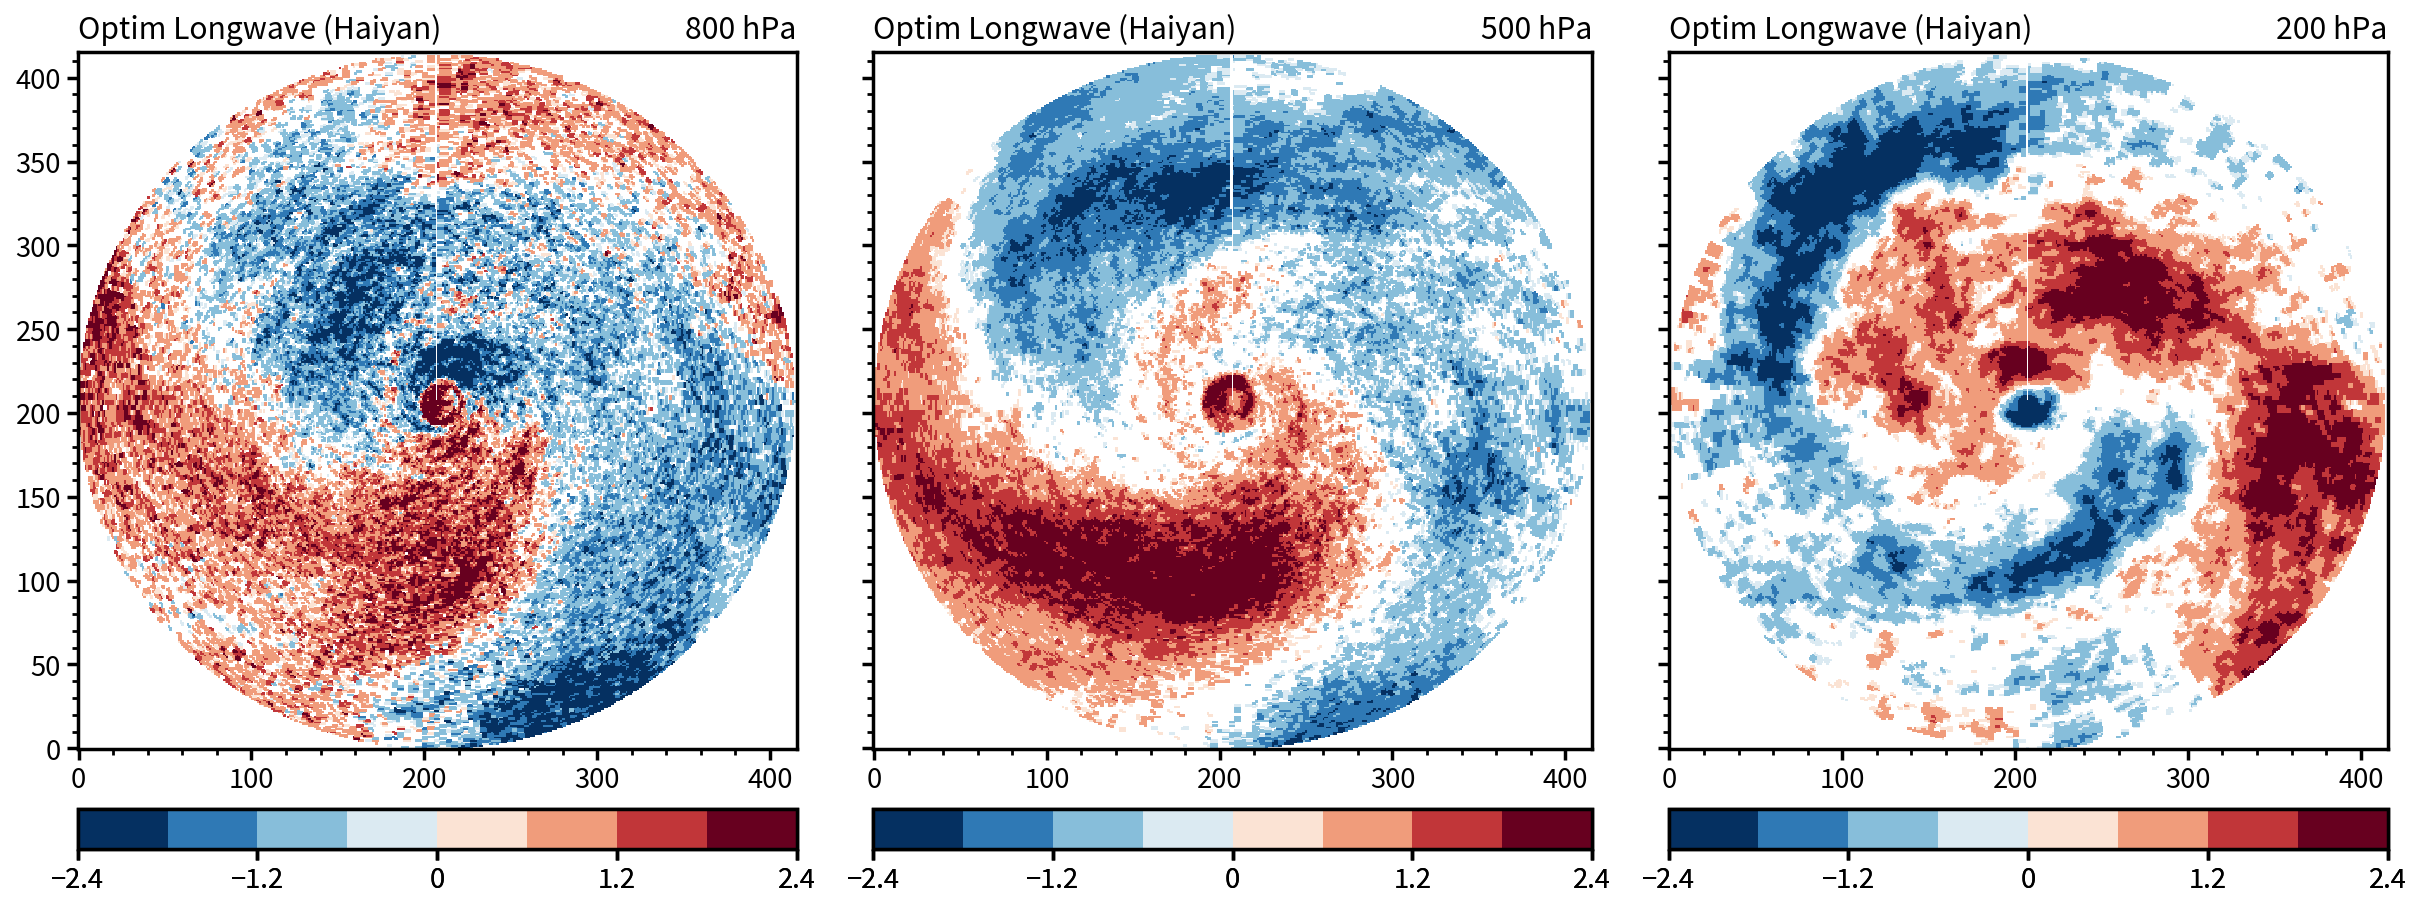

In [84]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'
def normalize(array):
    return (array-np.nanmean(array))/np.nanstd(array)

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.031)
pressurelevel = [800,500,200]
for i,obj in enumerate([2,5,-2]):
    maps = axs[i].pcolormesh(np.ma.masked_inside(normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(optimLW[int(obj),...],ANGLE,True,False)))),-.5,.5),cmap='BuRd',vmin=-3,vmax=3)
    axs[i].format(ltitle='Optim Longwave (Haiyan)',rtitle=f'{pressurelevel[i]} hPa')
    axs[i].colorbar(maps,loc='b')
plt.savefig('./pic/1228/optimLW.png',dpi=400)
plt.show()

/tmp/ipykernel_1541916/91580398.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


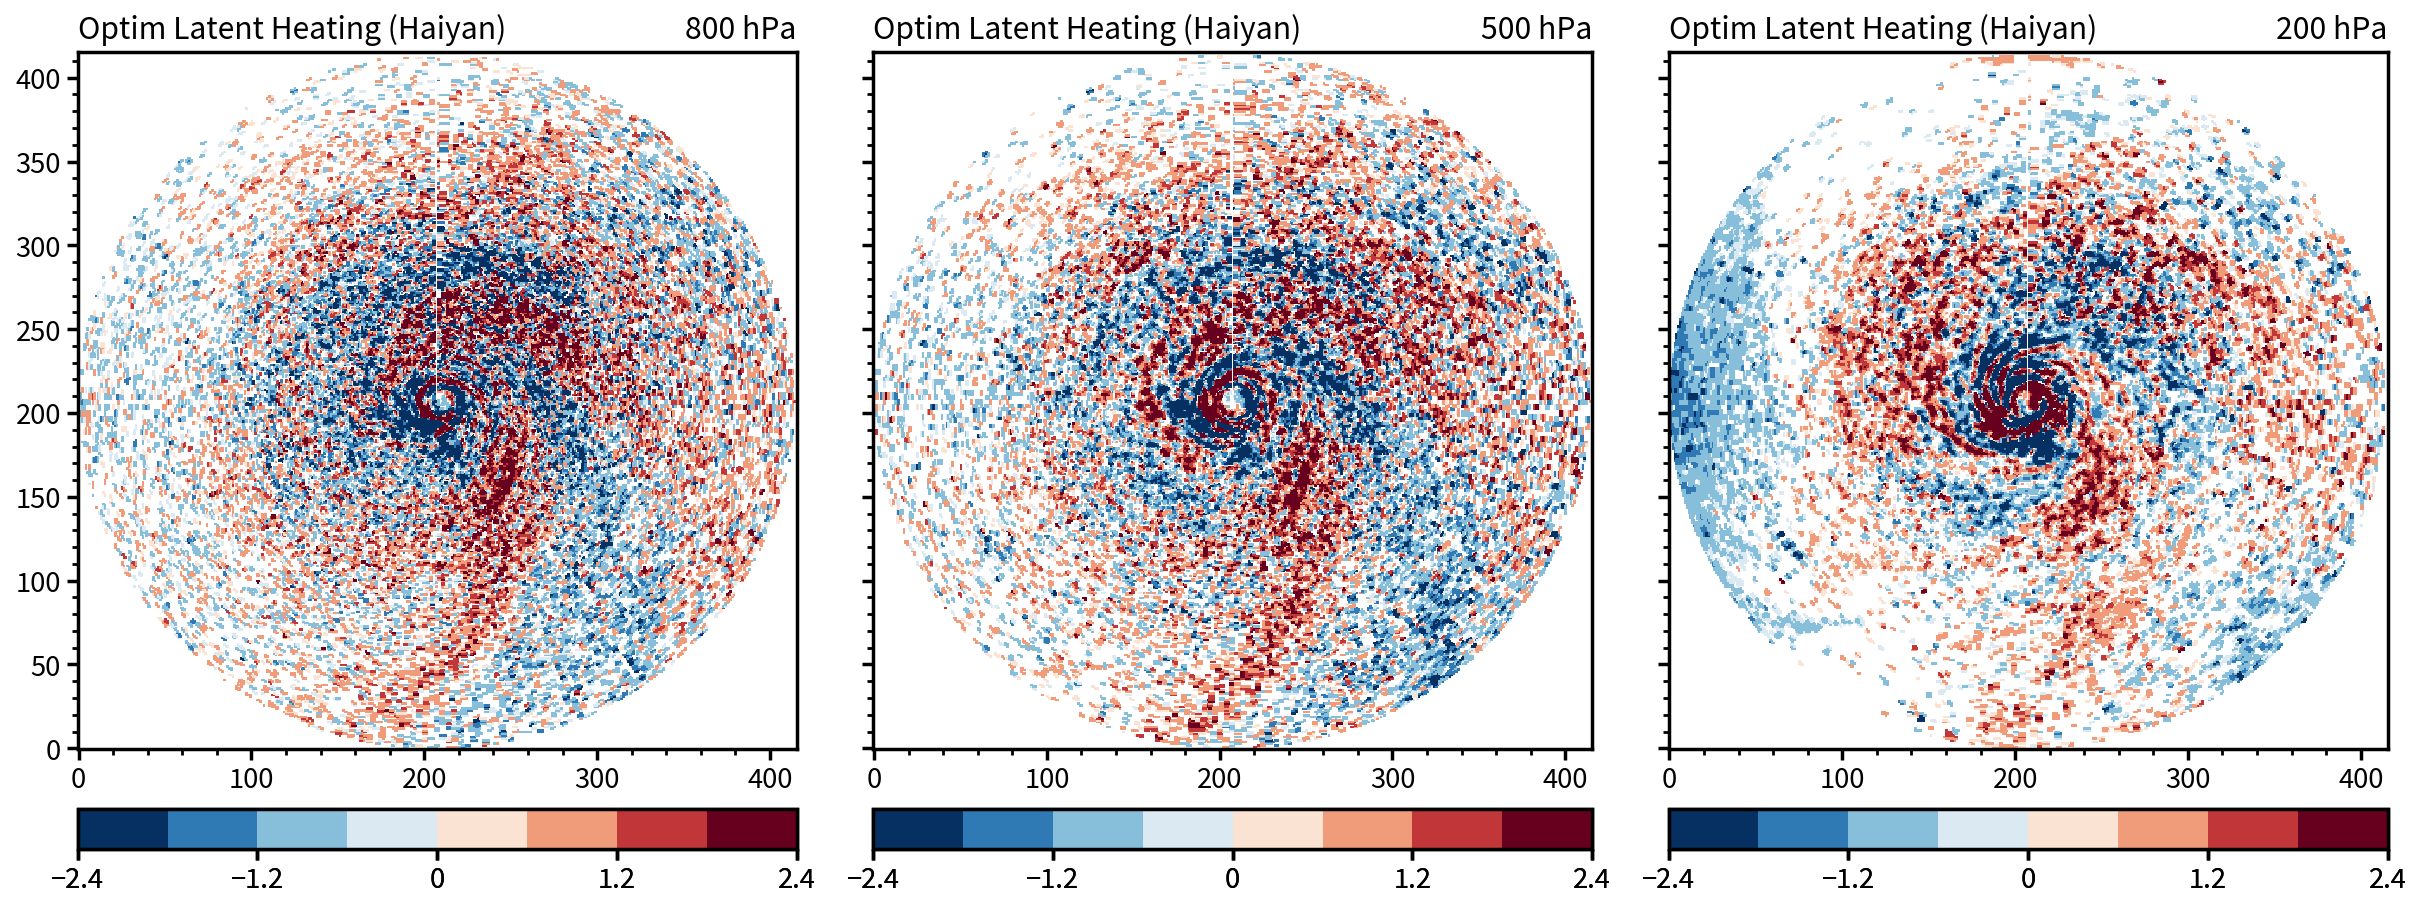

In [31]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.031)
pressurelevel = [800,500,200]
for i,obj in enumerate([2,5,-2]):
    maps = axs[i].pcolormesh(np.ma.masked_inside(normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(optimHDIA[int(obj),...],ANGLE,True,False)))),-.5,.5),cmap='BuRd',vmin=-3,vmax=3)
    axs[i].format(ltitle='Optim Latent Heating (Haiyan)',rtitle=f'{pressurelevel[i]} hPa')
    axs[i].colorbar(maps,loc='b')
plt.savefig('./pic/1228/optimHDIA.png',dpi=400)
plt.show()

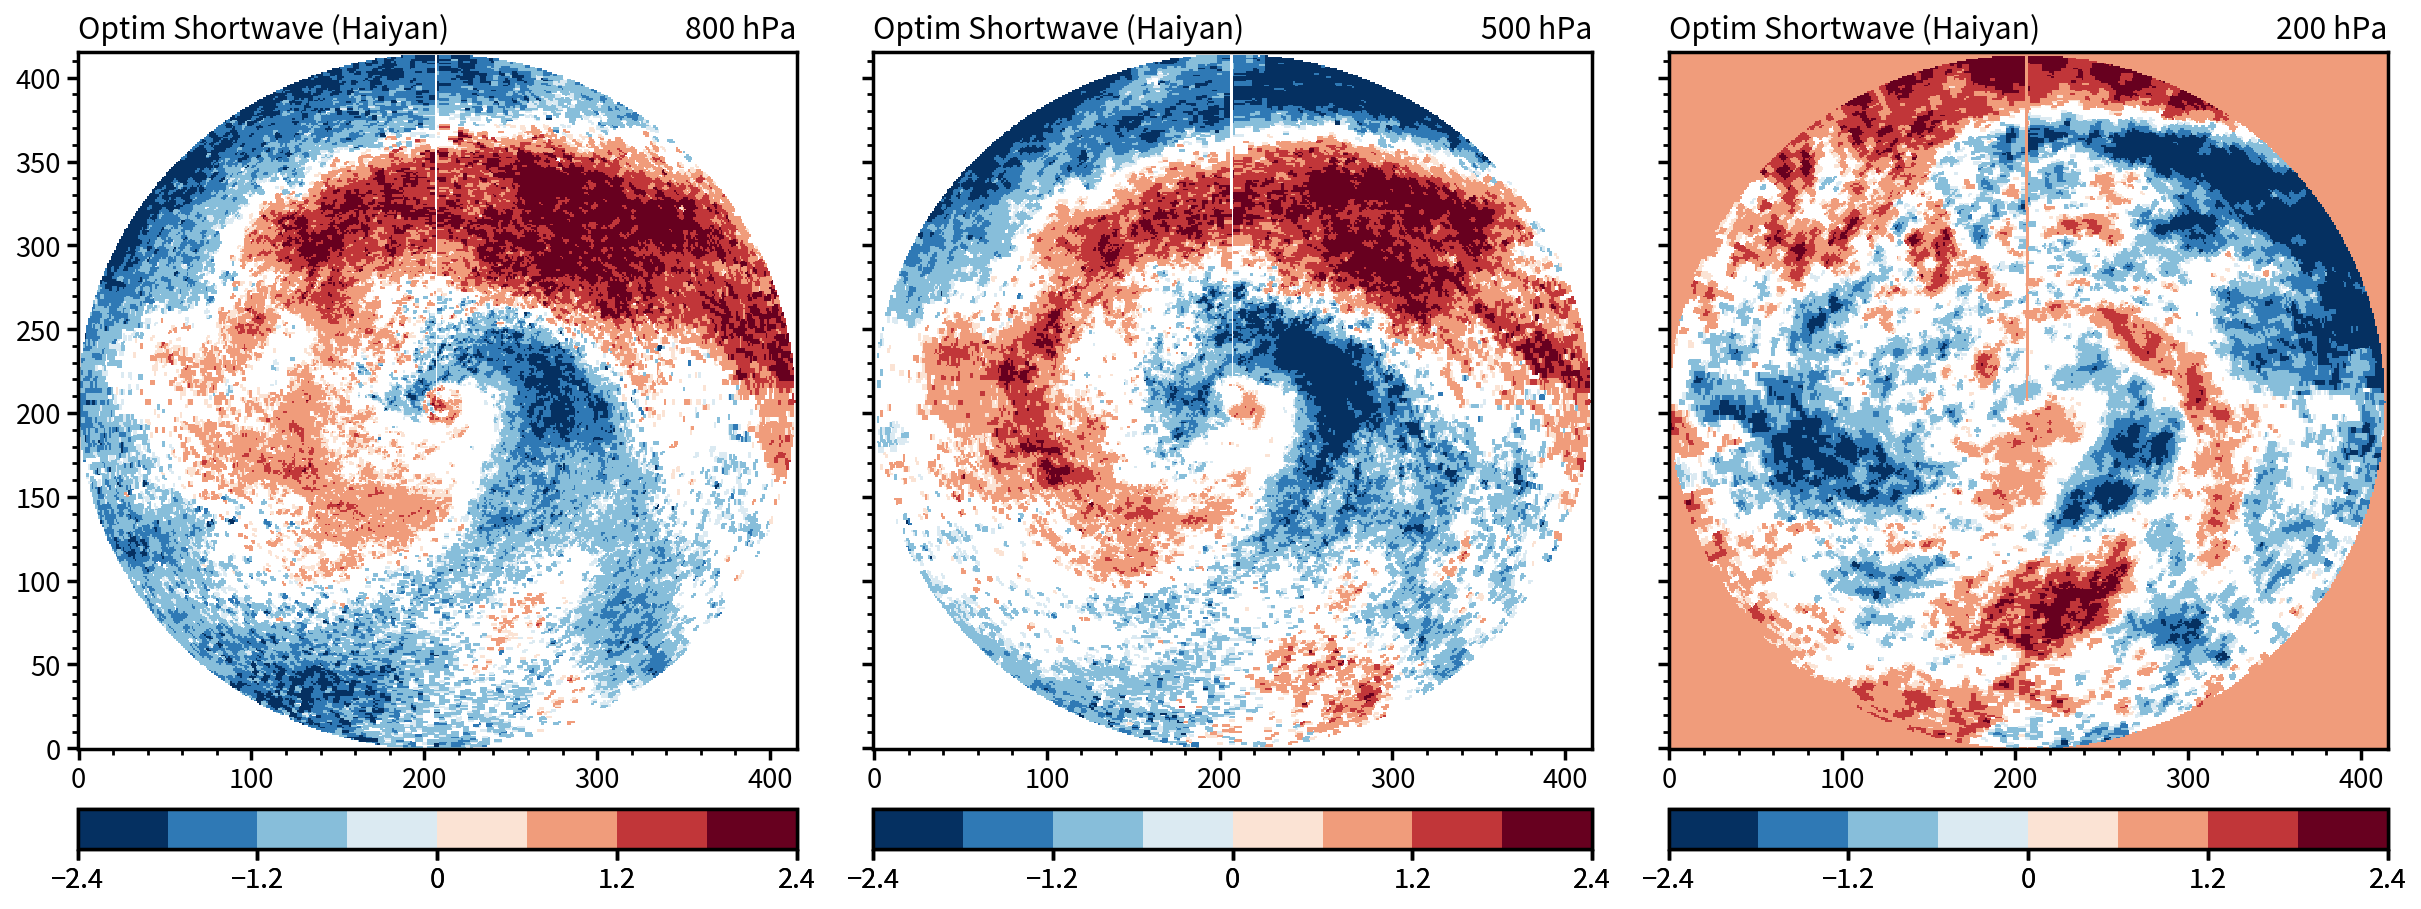

In [23]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.031)
pressurelevel = [800,500,200]
for i,obj in enumerate([2,5,-2]):
    maps = axs[i].pcolormesh(np.ma.masked_inside(normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(optimSW[int(obj),...],ANGLE,True,False)))),-.5,.5),cmap='BuRd',vmin=-3,vmax=3)
    #maps = axs[i].pcolormesh((np.fliplr(np.flipud(read_and_proc.proc_tocart(optimSW[int(obj),...],ANGLE,True,False)))),cmap='BuRd',vmin=-0.0003,vmax=0.0003)
    axs[i].format(ltitle='Optim Shortwave (Haiyan)',rtitle=f'{pressurelevel[i]} hPa')
    axs[i].colorbar(maps,loc='b')
plt.savefig('./pic/1228/optimSW_normal.png',dpi=400)
plt.show()

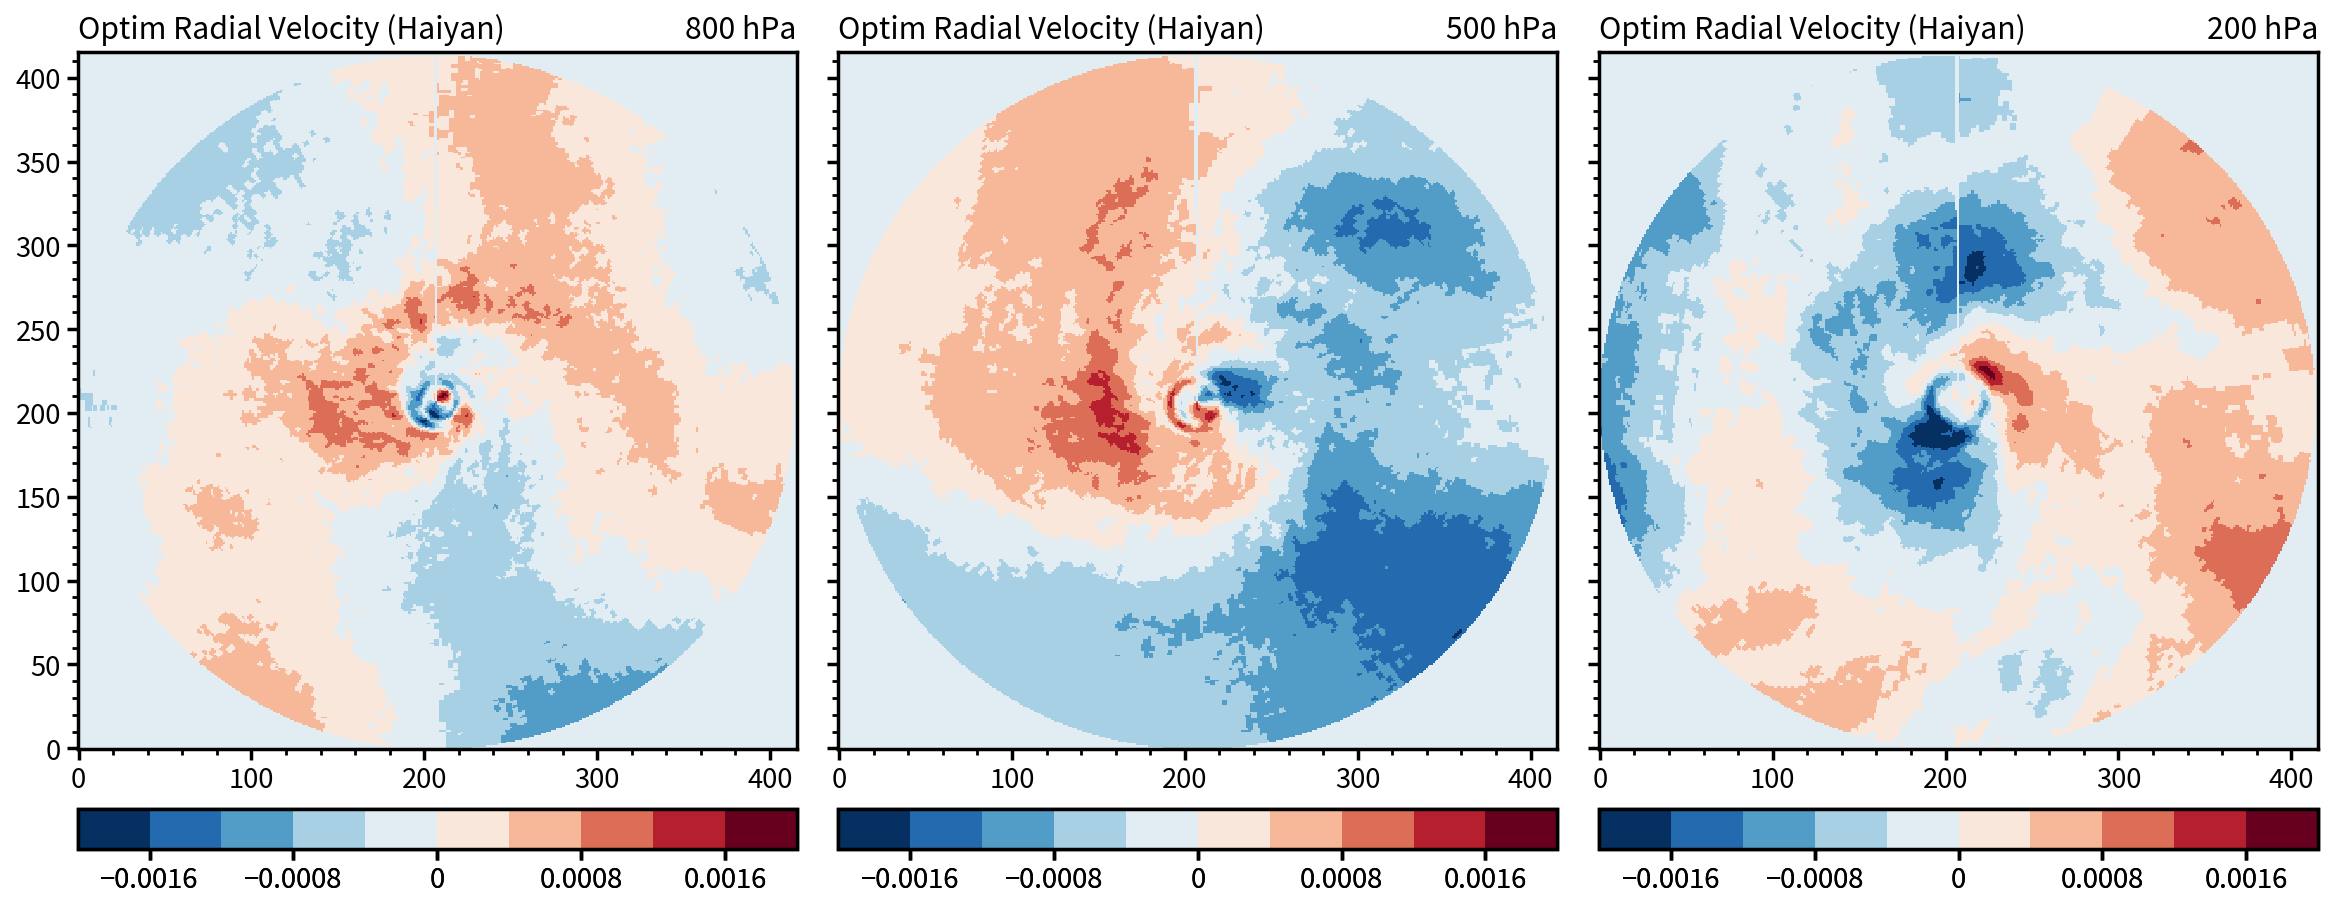

In [135]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.595,refaspect=1.031)
pressurelevel = [800,500,200]
for i,obj in enumerate([2,5,-2]):
    maps = axs[i].pcolormesh((np.fliplr(np.flipud(read_and_proc.proc_tocart(optimU[int(obj),...],ANGLE,True,False)))),cmap='BuRd',vmin=-0.002,vmax=0.002)
    #maps = axs[i].pcolormesh((np.fliplr(np.flipud(read_and_proc.proc_tocart(optimSW[int(obj),...],ANGLE,True,False)))),cmap='BuRd',vmin=-0.0003,vmax=0.0003)
    axs[i].format(ltitle='Optim Radial Velocity (Haiyan)',rtitle=f'{pressurelevel[i]} hPa')
    axs[i].colorbar(maps,loc='b')
plt.savefig('./pic/1228/optimU_simple.png',dpi=400)
plt.show()

In [70]:
timeseries_lw = np.dot(bestweights[5].detach().numpy(),normalize_timeseries(pcastore['lw'].transform(haiyan_data['lw'])[:,:20].T))

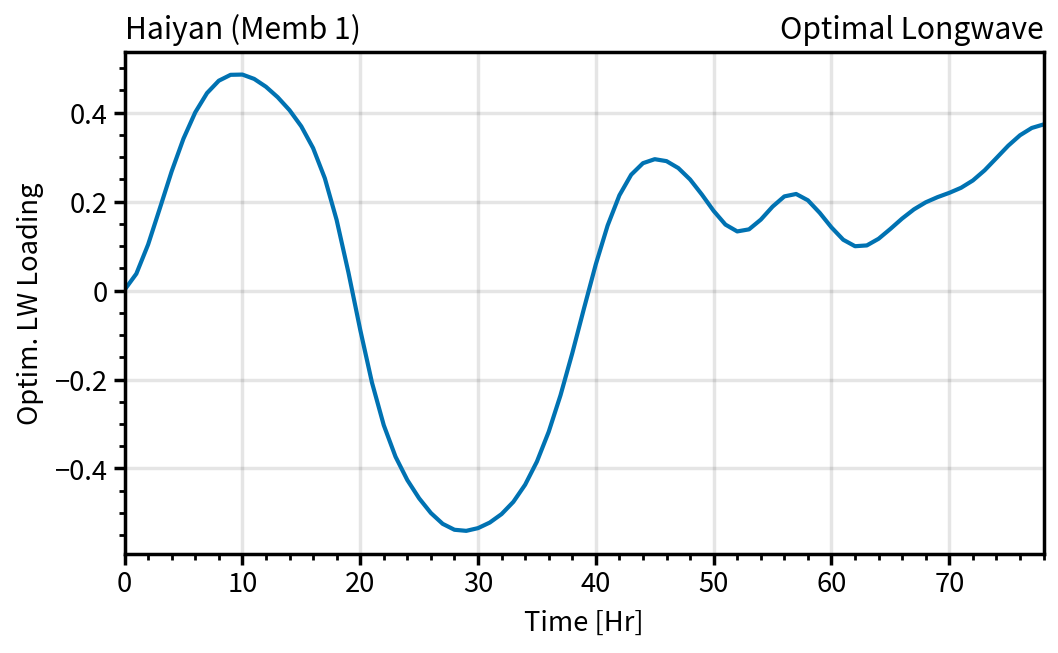

In [88]:
timeseries_lw = np.dot(bestweights[5].detach().numpy(),normalize_timeseries(pcastore['lw'].transform(haiyan_data['lw'])[:,:20].T))
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.595,refaspect=1.831)
axs.plot(np.squeeze(timeseries_lw)[0:79])
axs.format(xlabel='Time [Hr]',ylabel='Optim. LW Loading',ltitle='Haiyan (Memb 1)',rtitle='Optimal Longwave')
plt.savefig('./pic/1228/optim_LW_timeseries.png',dpi=400)
plt.show()

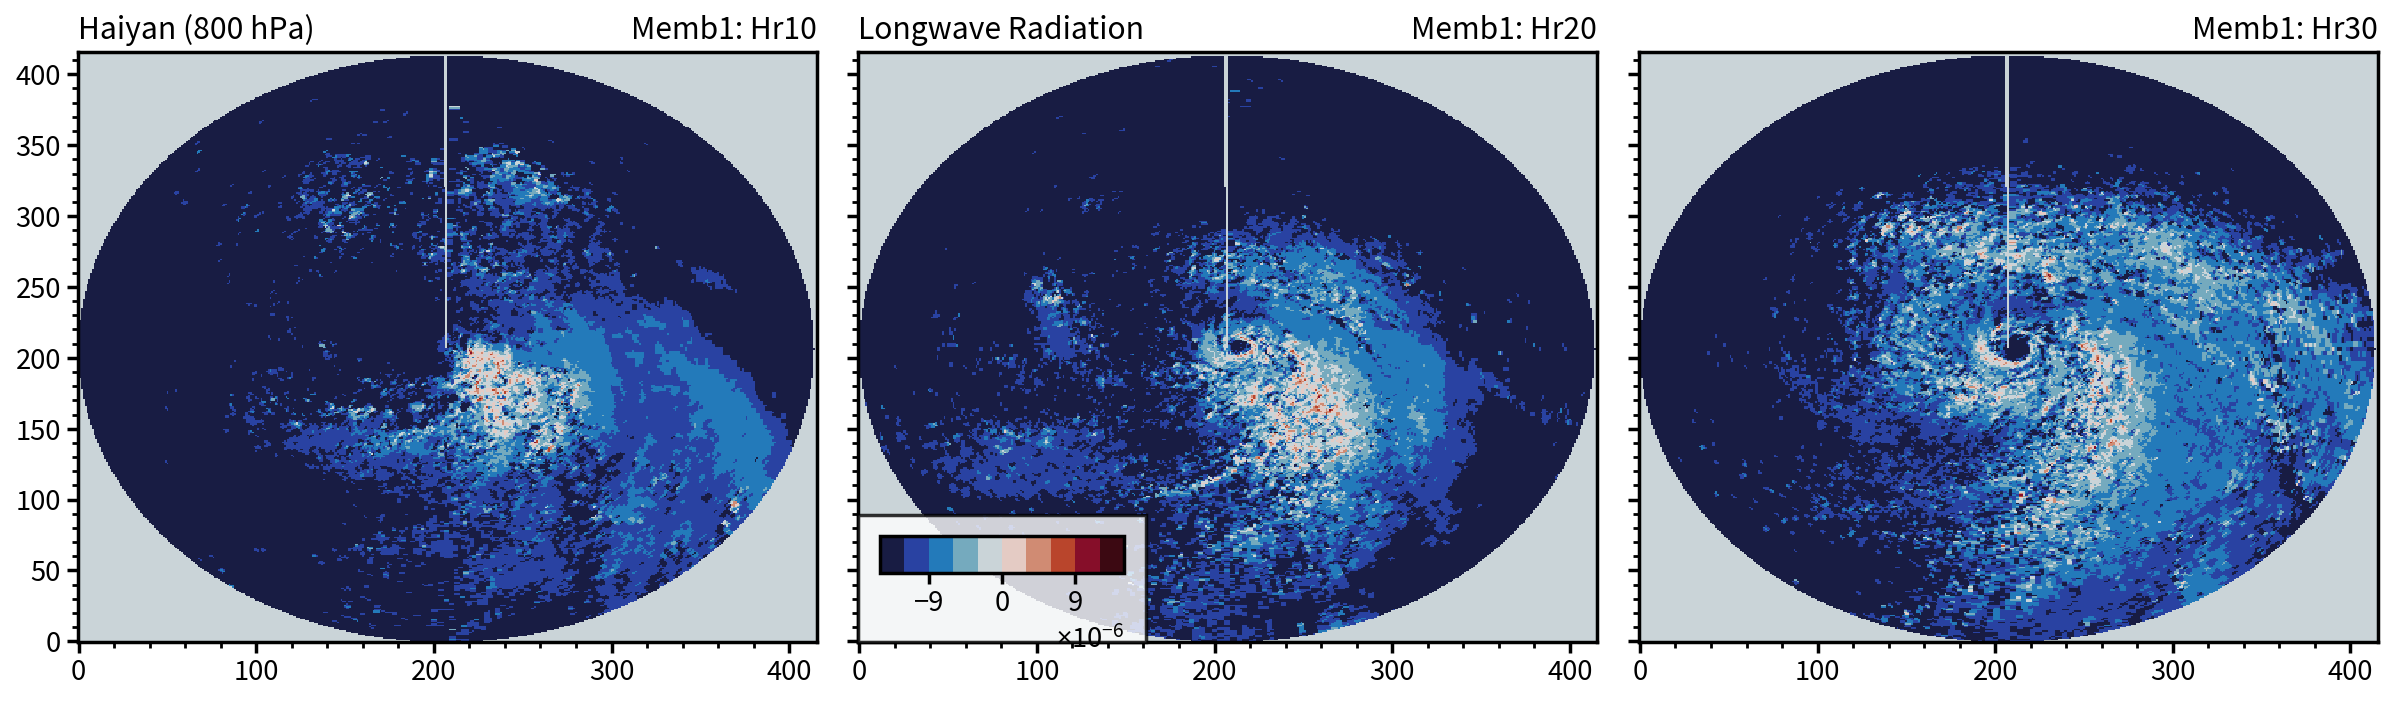

In [107]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.695,refaspect=1.2531)
axs[0].pcolormesh(np.fliplr(np.flipud(read_and_proc.proc_tocart(haiyan_data['lw'][10,...].reshape(10,360,208)[2,...],ANGLE,True,False))),vmin=-1.5e-5,vmax=1.5e-5,cmap='balance')
axs[1].pcolormesh((np.fliplr(np.flipud(read_and_proc.proc_tocart(haiyan_data['lw'][20,...].reshape(10,360,208)[2,...],ANGLE,True,False)))),vmin=-1.5e-5,vmax=1.5e-5,cmap='balance')
cmp = axs[2].pcolormesh((np.fliplr(np.flipud(read_and_proc.proc_tocart(haiyan_data['lw'][30,...].reshape(10,360,208)[2,...],ANGLE,True,False)))),vmin=-1.5e-5,vmax=1.5e-5,cmap='balance')
axs[1].colorbar(cmp,loc='ll')
axs[0].format(ltitle='Haiyan (800 hPa)',rtitle='Memb1: Hr10')
axs[1].format(ltitle='Longwave Radiation',rtitle='Memb1: Hr20')
axs[2].format(rtitle='Memb1: Hr30')
plt.savefig('./pic/1228/haiyan800_timespatial.png',dpi=400)
plt.show()

In [32]:
from metpy.calc import pressure_to_height_std
from metpy.units import units

In [65]:
import cmaps

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/lib/python3.9/site-packages/proplot/figure.py:1324: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  array = array.astype(np.int)
/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/lib/python3.9/site-packages/proplot/internals/process.py:84: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
D

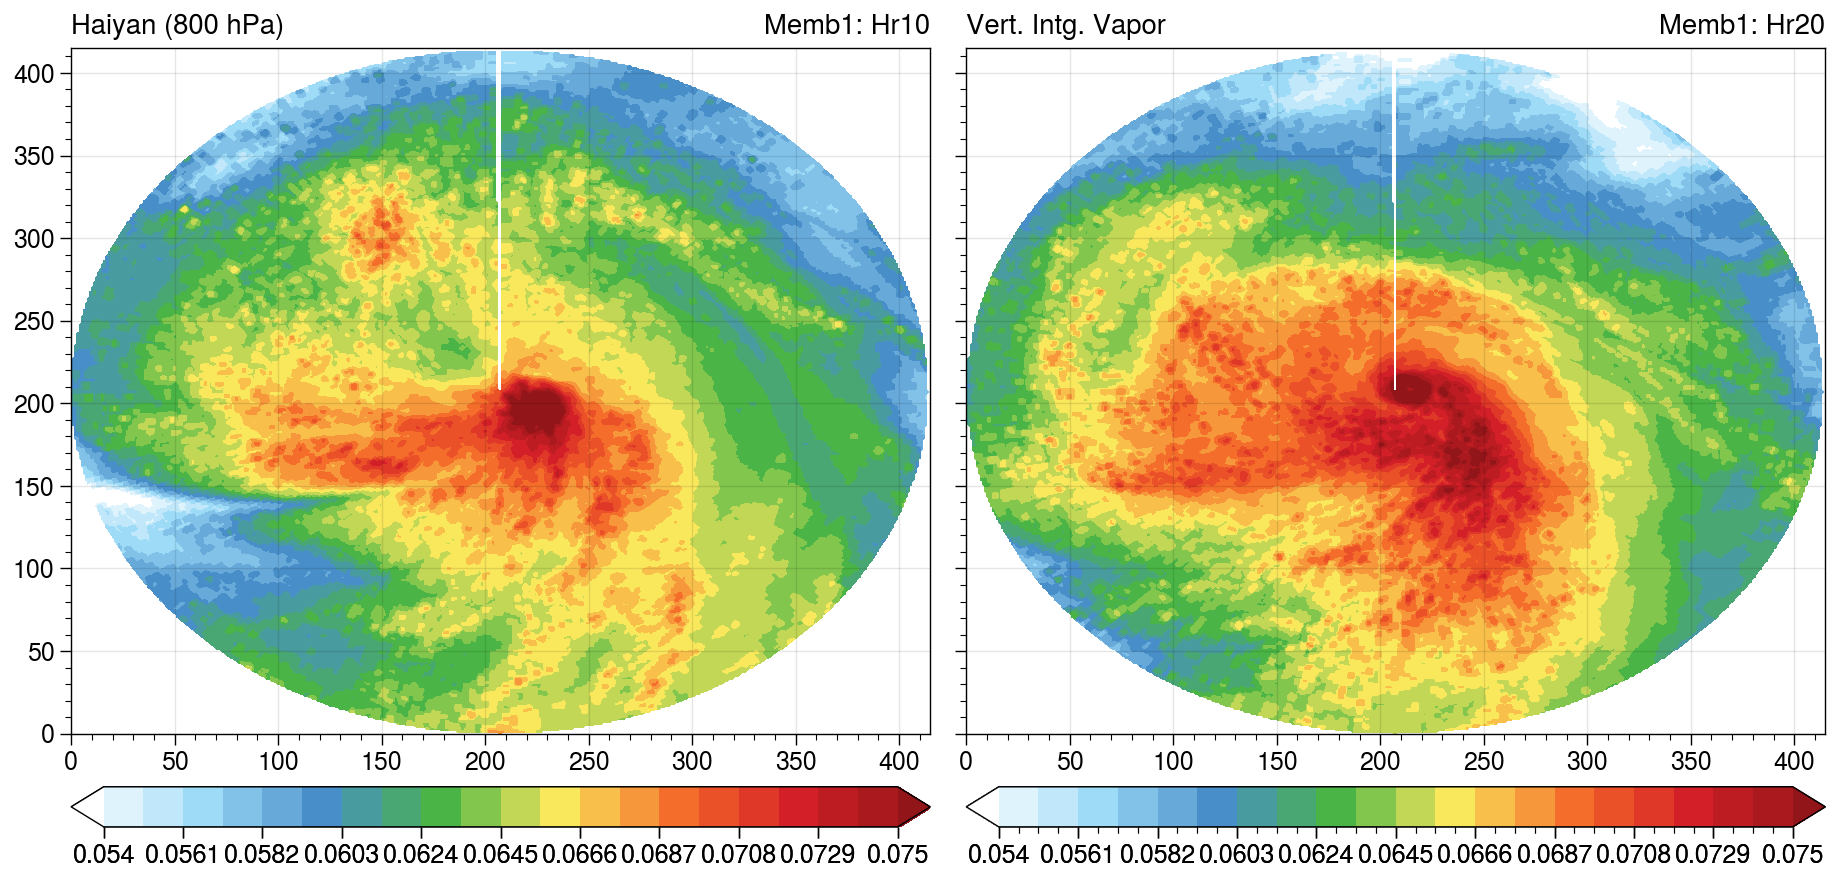

In [69]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.295,refaspect=1.2531)
toplot1 = np.trapz(haiyan_data['qv'][10,...].reshape(10,360,208),axis=0,x=pressure_to_height_std(np.linspace(1000,100,10)*units('hPa')).magnitude)
toplot2 = np.trapz(haiyan_data['qv'][20,...].reshape(10,360,208),axis=0,x=pressure_to_height_std(np.linspace(1000,100,10)*units('hPa')).magnitude)
#toplot3 = np.trapz(haiyan_data['qv'][30,...].reshape(10,360,208),axis=0,x=pressure_to_height_std(np.linspace(1000,100,10)*units('hPa')).magnitude)

axs[0].contourf(np.ma.masked_less(np.fliplr(np.flipud(read_and_proc.proc_tocart(toplot1,ANGLE,True,False))),0.016),levels=np.linspace(0.054,0.075,21),cmap=cmaps.WhiteBlueGreenYellowRed,extend='both')
cmp = axs[1].contourf(np.ma.masked_less((np.fliplr(np.flipud(read_and_proc.proc_tocart(toplot2,ANGLE,True,False)))),0.016),levels=np.linspace(0.054,0.075,21),cmap=cmaps.WhiteBlueGreenYellowRed,extend='both')
#cmp = axs[2].contourf(np.ma.masked_less((np.fliplr(np.flipud(read_and_proc.proc_tocart(toplot3,ANGLE,True,False)))),0.016),levels=np.linspace(0.054,0.075,21),cmap=cmaps.WhiteBlueGreenYellowRed,extend='both')
axs[1].colorbar(cmp,loc='b')
axs[0].colorbar(cmp,loc='b')
#axs[2].colorbar(cmp,loc='b')

axs[0].format(ltitle='Haiyan (800 hPa)',rtitle='Memb1: Hr10')
axs[1].format(ltitle='Vert. Intg. Vapor',rtitle='Memb1: Hr20')
#axs[2].format(rtitle='Memb1: Hr30')
plt.savefig('./pic/1228/haiyan800_timespatial-intwv.png',dpi=400)
plt.show()

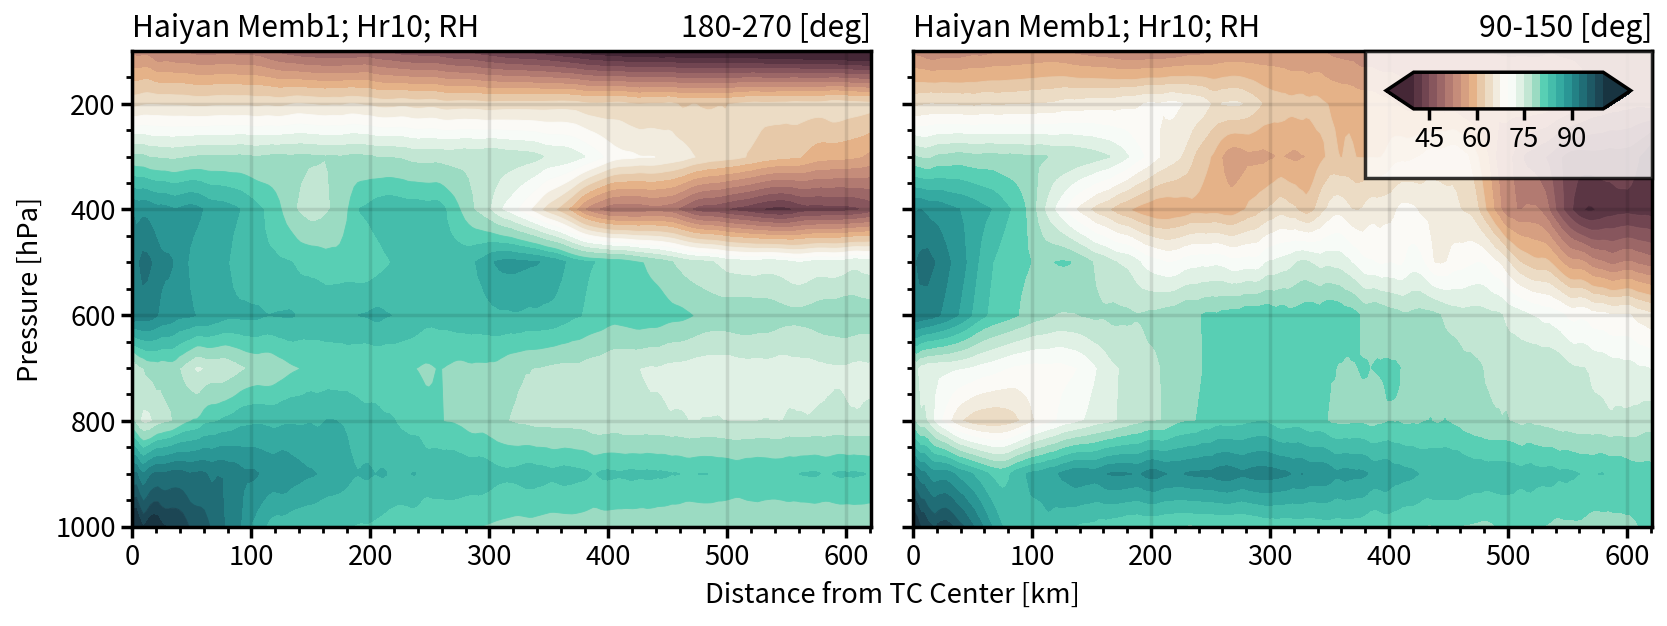

In [117]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.695,refaspect=1.5531)
axs[0].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(haiyan_data['rh'][10,...].reshape(10,360,208)[:,180:270,:],axis=1)*100,levels=np.linspace(40,100,25),cmap='DryWet',extend='both')
cmp = axs[1].contourf(np.linspace(0,207,208)*3,np.linspace(1000,100,10),np.mean(haiyan_data['rh'][10,...].reshape(10,360,208)[:,90:150,:],axis=1)*100,levels=np.linspace(40,100,25),cmap='DryWet',extend='both')
axs[1].colorbar(cmp,loc='ur')
axs.format(xlabel='Distance from TC Center [km]',ylabel='Pressure [hPa]',ltitle='Haiyan Memb1; Hr10; RH')
axs[0].format(rtitle='180-270 [deg]')
axs[1].format(rtitle='90-150 [deg]')
plt.ylim(1000,100)
plt.savefig('./pic/1228/RH_10.png',dpi=400)
plt.show()

### Marginal Dependence

In [120]:
X_origtensor,y_origtensor,data = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,linear='No',nonlnnum=3)._get_tensors(splitnum=2,exp='lwswdtthuvw')

In [142]:
hiallv = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,
                                linear='No',nonlnnum=3).onepred_to_4d(pred=bestmodel[0](X_origtensor['train']).detach().numpy(),target='all')

In [33]:
from copy import deepcopy
def marginal_dependence(model=None,Xtensor=None,perturbindex=None,perturbation=np.linspace(-4,4,50),target='mean_WSURF'):
    if isinstance(perturbindex,int):
        if target=='mean_WSURF':
            store = []
            for i in list(perturbation):
                noLW = deepcopy(Xtensor.detach().numpy())
                noLW[:,perturbindex] = i*noLW[:,perturbindex]
                noLW = torch.FloatTensor(noLW).to('cpu')
                noLWpred = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,
                                linear='No',nonlnnum=3).onepred_to_4d(pred=model[0](noLW).detach().numpy(),target='4layers')
                store.append(np.mean((noLWpred['v'][0]**2+noLWpred['u'][0]**2)**(0.5),axis=1))
    elif isinstance(perturbindex,list):
        if target=='mean_WSURF':
            store = []
            for i in list(perturbation):
                noLW = deepcopy(Xtensor.detach().numpy())
                noLW[:,perturbindex[0]:perturbindex[1]+1] = i*noLW[:,perturbindex[0]:perturbindex[1]+1]
                noLW = torch.FloatTensor(noLW).to('cpu')
                noLWpred = analysis_trainedmodels(folderpath,folderpath2,pcastore=pcastore,divider=divider,comps=[50,38,8],Xtrain=Xtrain,Xvalid=Xvalid,Xtest=Xtest,yall=yall,
                                linear='No',nonlnnum=3).onepred_to_4d(pred=model[0](noLW).detach().numpy(),target='4layers')
                store.append(np.mean((noLWpred['v'][0]**2+noLWpred['u'][0]**2)**(0.5),axis=1))            
                
    return store

In [35]:
PDP_SW = marginal_dependence(bestmodel,X_origtensor['train'],[289,309],np.linspace(0,1,21),'mean_WSURF') #[309,329]
PDP_LW = marginal_dependence(bestmodel,X_origtensor['train'],[269,289],np.linspace(0,1,21),'mean_WSURF') #[309,329]
PDP_HDIA = marginal_dependence(bestmodel,X_origtensor['train'],[187,269],np.linspace(0,1,21),'mean_WSURF') #[309,329]
PDP_U = marginal_dependence(bestmodel,X_origtensor['train'],[0,50],np.linspace(0,1,21),'mean_WSURF')
PDP_V = marginal_dependence(bestmodel,X_origtensor['train'],[50,88],np.linspace(0,1,21),'mean_WSURF')
PDP_W = marginal_dependence(bestmodel,X_origtensor['train'],[88,179],np.linspace(0,1,21),'mean_WSURF')

In [202]:
PDP_LW0 = marginal_dependence(bestmodel,X_origtensor['train'],269,np.linspace(-2,2,21),'mean_WSURF') #[309,329]
PDP_LW1 = marginal_dependence(bestmodel,X_origtensor['train'],270,np.linspace(-2,2,21),'mean_WSURF') #[309,329]
PDP_LW2 = marginal_dependence(bestmodel,X_origtensor['train'],271,np.linspace(-2,2,21),'mean_WSURF') 
PDP_LW3 = marginal_dependence(bestmodel,X_origtensor['train'],272,np.linspace(-2,2,21),'mean_WSURF')
PDP_LW4 = marginal_dependence(bestmodel,X_origtensor['train'],273,np.linspace(-2,2,21),'mean_WSURF')
PDP_LW5 = marginal_dependence(bestmodel,X_origtensor['train'],274,np.linspace(-2,2,21),'mean_WSURF') 
PDP_LW6 = marginal_dependence(bestmodel,X_origtensor['train'],275,np.linspace(-2,2,21),'mean_WSURF') #[309,329]
#PDP_U = marginal_dependence(bestmodel,X_origtensor['train'],[0,50],np.linspace(0,1,21),'mean_WSURF') #[309,329]

In [55]:
normalize(np.fliplr(np.flipud(read_and_proc.proc_tocart(np.nanmean(haiyan_data['lw'][20:30,...],axis=0).reshape(10,360,208)[2,...],ANGLE,True,False))))

array([[1.3987814, 1.3987814, 1.3987814, ..., 1.3987814, 1.3987814,
        1.3987814],
       [1.3987814, 1.3987814, 1.3987814, ..., 1.3987814, 1.3987814,
        1.3987814],
       [1.3987814, 1.3987814, 1.3987814, ..., 1.3987814, 1.3987814,
        1.3987814],
       ...,
       [1.3987814, 1.3987814, 1.3987814, ..., 1.3987814, 1.3987814,
        1.3987814],
       [1.3987814, 1.3987814, 1.3987814, ..., 1.3987814, 1.3987814,
        1.3987814],
       [1.3987814, 1.3987814, 1.3987814, ..., 1.3987814, 1.3987814,
        1.3987814]], dtype=float32)

In [42]:
def normalize_timeseries(timeseries=None):
    #assert timeseries['u'].shape[-1]==26,"var shape error"
    obj = (timeseries-np.nanmean(timeseries,axis=0))/np.nanstd(timeseries,axis=0)
    return obj

In [43]:
timeseries_lw = np.dot(bestweights[5].data.numpy(),normalize_timeseries(pcastore['lw'].transform(haiyan_data['lw'])[:,:20].T))
timeseries_sw = np.dot(bestweights[6].data.numpy(),normalize_timeseries(pcastore['sw'].transform(haiyan_data['sw'])[:,:20].T))

### R2 analyais

In [15]:
def r2_score(truth=None,pred=None):
    MSE = np.sum((truth-pred)**2)
    var = np.sum((truth-np.mean(truth))**2)
    return 1-MSE/var

def store_r2(pcastore=None,yTRUTH=None,model=None,splitnum=30,Xtensor=None,category='test',origYs=None,comps=None):
    folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
    folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
    #Xtensor,ytensor,data,models = output_processed(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,splitnum)
    if origYs:
        if category=='test':
            orig_tests = origYs[2]
        elif category=='valid':
            orig_tests =  origYs[1]
        elif category=='train':
            orig_tests =  origYs[0]
    
    bbbbbb_th = np.dot(model[0](Xtensor[category]).detach().numpy()[:,comps[0]+comps[1]:comps[0]+comps[1]+comps[2]],pcastore['theta'].components_[:comps[2]])
    #bbbbbb_w = np.dot(model[0](Xtensor[category]).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    bbbbbb_v = np.dot(model[0](Xtensor[category]).detach().numpy()[:,comps[0]:comps[0]+comps[1]],pcastore['v'].components_[:comps[1]])
    bbbbbb_u = np.dot(model[0](Xtensor[category]).detach().numpy()[:,:comps[0]],pcastore['u'].components_[:comps[0]])
    
    splitnum2=0
    uper = r2_score(yTRUTH[category][splitnum2]['du'],bbbbbb_u)
    vper = r2_score(yTRUTH[category][splitnum2]['dv'],bbbbbb_v)
    thper = r2_score(yTRUTH[category][splitnum2]['dth'],bbbbbb_th)
    return {'u':uper,'v':vper,'theta':thper}

import pandas as pd
def __store_r2(TYPE='test',yorigs=None,linear='Yes',nonlnnum=None):
    storemodels = []
    storeorig = []
    allmodels = []
    for split in tqdm(range(33)):
        folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
        folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/new3D/'
        yTRUTH = read.train_optimizedMLR(folderpath,folderpath2,'rhorig','rhorig','3D').y_truth(divider=divider,lti=24,num=33,withW=False,splitnum=[split])
        origr2,newr2 = [],[]
        Xtensor,ytensor,data,models = output_processed(Xtrain,Xvalid,Xtest,yall,folderpath,folderpath2,split,linear,nonlnnum)
        xgmodl = []
        for i in range(len(models)):
            #a,b = store_r2(pcastore=pcastore,yTRUTH=yTRUTH,model=models[i],splitnum=split,Xtensor=Xtensor,category=TYPE,origYs=yorigs)
            #origr2.append(a)
            b = store_r2(pcastore=pcastore,yTRUTH=yTRUTH,model=models[i],splitnum=split,Xtensor=Xtensor,category=TYPE,origYs=yorigs,comps=[50,38,8])
            newr2.append(b)
            xgmodl.append(models[i])
        X = pd.DataFrame.from_dict({'u':[obj['u'] for obj in newr2],'v':[obj['v'] for obj in newr2],'theta':[obj['theta'] for obj in newr2]})
        storemodels.append(X)
        #storeorig.append(origr2)
        allmodels.append(xgmodl)
        print(np.asarray(X['v']).max())
        del yTRUTH
        gc.collect()
        
    allpd = pd.concat(objs=(iDF for iDF in storemodels),axis=0, join='inner').reset_index()
    allpds = allpd.drop(columns=['index'])
    #storeMLR = [storeorigobj[0] for storeorigobj in storeorig]
    #MLRX = pd.DataFrame.from_dict({'u':[obj['u'] for obj in storeMLR],'v':[obj['v'] for obj in storeMLR],'w':[obj['w'] for obj in storeMLR],'theta':[obj['theta'] for obj in storeMLR]})
    allpd_out = pd.concat(objs=(allpds.drop(columns=['w']),MLRX.drop(columns=['w'])),axis=0,join='inner').reset_index()
    allpd_outs = allpd_out.drop(columns=['index'])
    allpds_copy = allpds.copy()
    allpds_copy['mean'] = (allpds_copy['u']+allpds_copy['v']+allpds_copy['theta'])/3
    allpds_copy.sort_values(by=['mean'], ascending=False)
    return storemodels,allmodels,{'v2':allpds_copy,'v1_torch':allpds}

In [19]:
#train_storemls,train_allmdls,train_allpds = __store_r2('train',None,'Yes',None)#[orig_trainY,orig_validY,orig_testY],'Yes',None)
test_storemls,test_allmdls,test_allpds = __store_r2('test',None,'Yes',None)#[orig_trainY,orig_validY,orig_testY],'Yes',None)

  0%|          | 0/33 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.40850878377909783


0it [00:00, ?it/s]

0.21084640317301107


0it [00:00, ?it/s]


KeyboardInterrupt



In [20]:
test_storemls,test_allmdls,test_allpds = __store_r2('test',None,'No',9)#[orig_trainY,orig_validY,orig_testY],'Yes',None)

  0%|          | 0/33 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.5030243189816188


0it [00:00, ?it/s]

0.47630513592607737


0it [00:00, ?it/s]

0.5972977613959276


0it [00:00, ?it/s]

0.4100125302326001


0it [00:00, ?it/s]

0.4570760928531977


0it [00:00, ?it/s]

0.4513115661554191


0it [00:00, ?it/s]

0.44038098836606554


0it [00:00, ?it/s]

0.4872985381283036


0it [00:00, ?it/s]

0.5650935258789442


0it [00:00, ?it/s]

0.48617799297301234


0it [00:00, ?it/s]

0.5061440272587916


0it [00:00, ?it/s]

0.5056251770599216


0it [00:00, ?it/s]

0.28625275698793307


0it [00:00, ?it/s]

0.47390066604535996


0it [00:00, ?it/s]

0.42291671123438923


0it [00:00, ?it/s]

0.28518590913583364


0it [00:00, ?it/s]

0.3790715354431715


0it [00:00, ?it/s]

0.5114341416998747


0it [00:00, ?it/s]

0.36384236811230775


0it [00:00, ?it/s]

0.3682375202405974


0it [00:00, ?it/s]

0.40612354703787656


0it [00:00, ?it/s]

0.3746326160758763


0it [00:00, ?it/s]

0.4717932231834119


0it [00:00, ?it/s]

0.5169111781905089


0it [00:00, ?it/s]

0.5840681311248903


0it [00:00, ?it/s]

0.43939365871026403


0it [00:00, ?it/s]

0.48287352391391747


0it [00:00, ?it/s]

0.4818920527587932


0it [00:00, ?it/s]

0.4460305463946467


0it [00:00, ?it/s]

0.4509826818080408


0it [00:00, ?it/s]

0.2857909416645512


0it [00:00, ?it/s]

0.40734159340068565


0it [00:00, ?it/s]

0.3309563258068997


KeyError: "['w'] not found in axis"

In [23]:
test_storemls

NameError: name 'test_storemls' is not defined

/tmp/ipykernel_3108678/3154569310.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


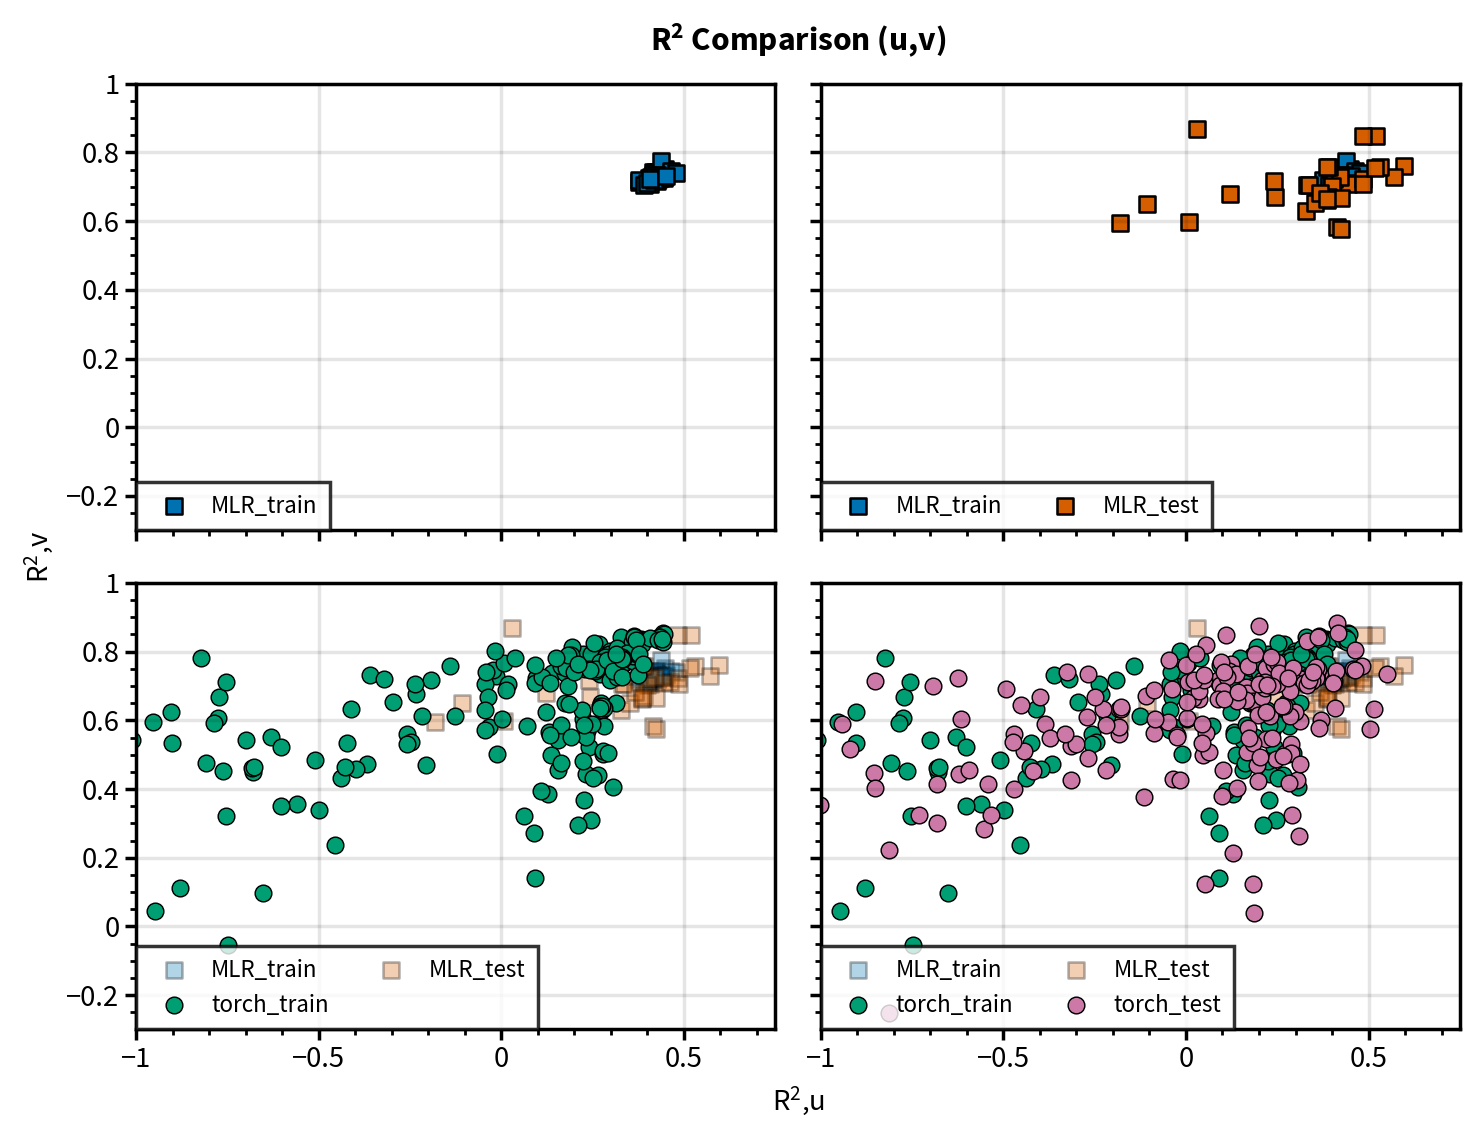

In [60]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

indx=1
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=3.195,refaspect=1.431)
#axs[0].scatter(train_allpds['v1_torch']['u'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k')
#axs[0].scatter(test_allpds['v1_torch']['u'],test_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k')
axs[0].scatter(train_allpds['v1_mlr']['u'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train')
axs[0].legend(loc='ll',prop={'size':9})
axs[1].scatter(train_allpds['v1_mlr']['u'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train')
axs[1].scatter(test_allpds['v1_mlr']['u'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test')
axs[1].legend(loc='ll',prop={'size':9})
axs[2].scatter(train_allpds['v1_mlr']['u'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train',alpha=0.3)
axs[2].scatter(test_allpds['v1_mlr']['u'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test',alpha=0.3)
axs[2].scatter(train_allpds['v1_torch']['u'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_train')
axs[2].legend(loc='ll',ncols=2,prop={'size':9})
axs[3].scatter(train_allpds['v1_mlr']['u'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train',alpha=0.3)
axs[3].scatter(test_allpds['v1_mlr']['u'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test',alpha=0.3)
axs[3].scatter(train_allpds['v1_torch']['u'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_train')
axs[3].scatter(test_allpds['v1_torch']['u'],test_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_test')
axs[3].legend(loc='ll',ncols=2,prop={'size':9})
axs.format(xlim=[-1,0.75],ylim=[-0.3,1],xlabel=r'R$^{2}$,u',ylabel=r'R$^{2}$,v',suptitle=r'R$^{2}$ Comparison (u,v)')
plt.savefig('./pic/proposal/r2_uv.png',dpi=300)
plt.show()

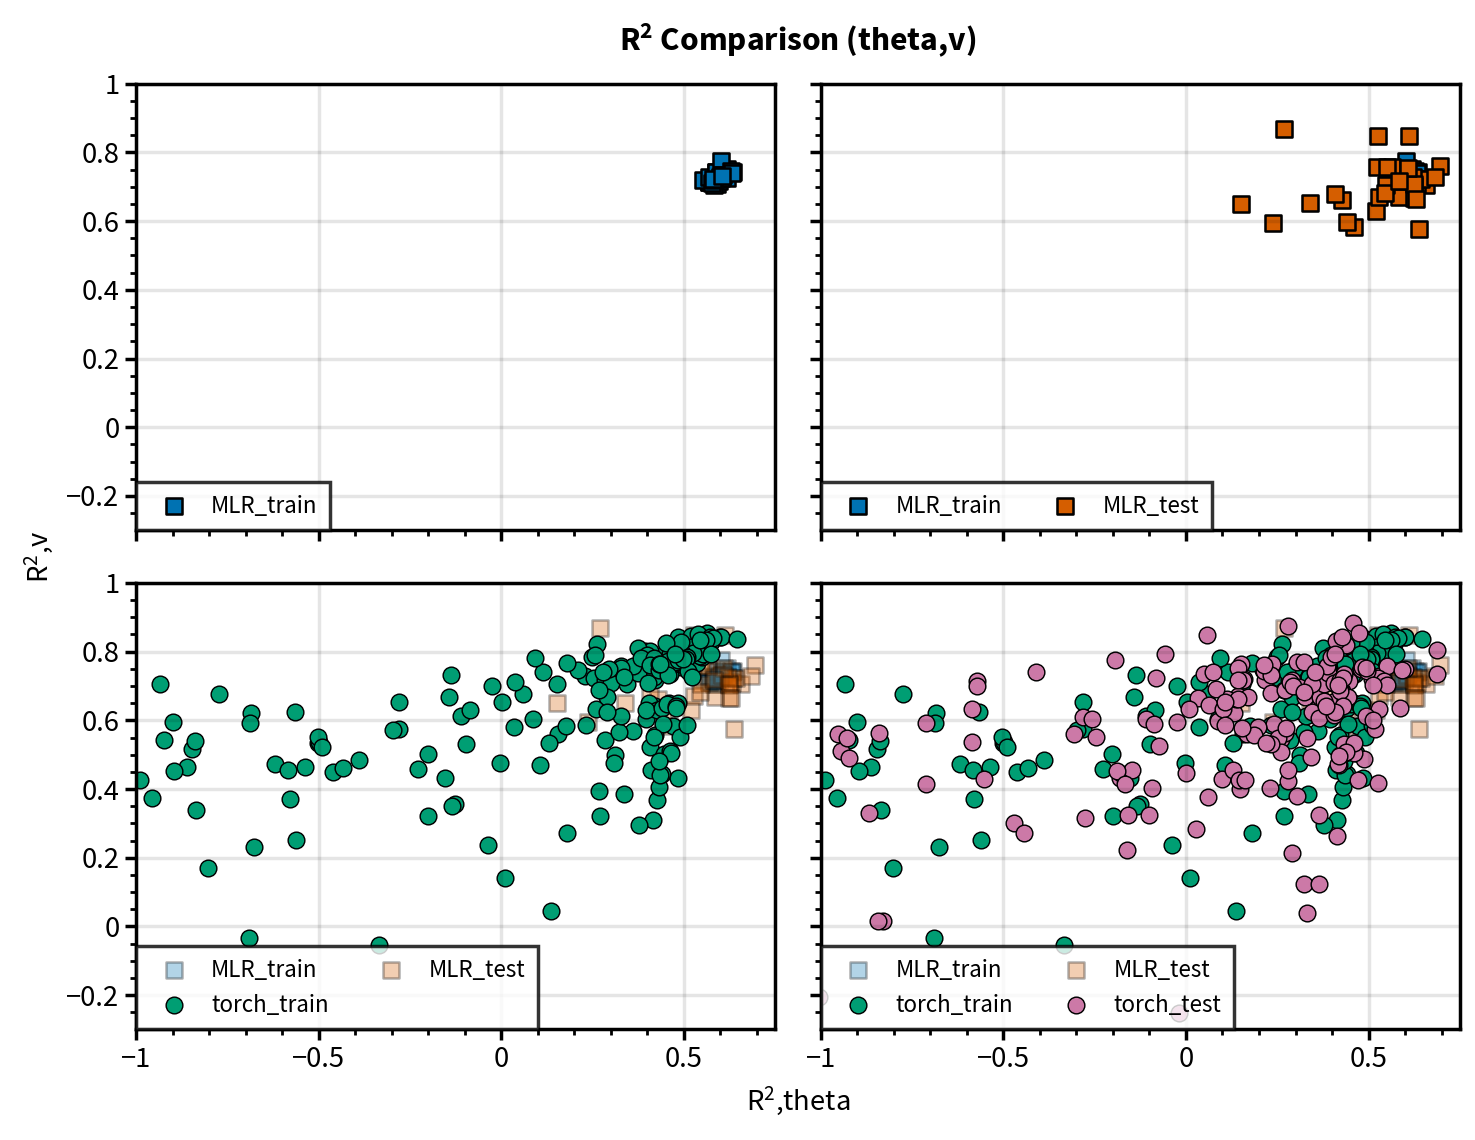

In [62]:
fig,axs = plot.subplots(ncols=2,nrows=2,axwidth=3.195,refaspect=1.431)
#axs[0].scatter(train_allpds['v1_torch']['u'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k')
#axs[0].scatter(test_allpds['v1_torch']['u'],test_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k')
axs[0].scatter(train_allpds['v1_mlr']['theta'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train')
axs[0].legend(loc='ll',prop={'size':9})
axs[1].scatter(train_allpds['v1_mlr']['theta'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train')
axs[1].scatter(test_allpds['v1_mlr']['theta'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test')
axs[1].legend(loc='ll',prop={'size':9})
axs[2].scatter(train_allpds['v1_mlr']['theta'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train',alpha=0.3)
axs[2].scatter(test_allpds['v1_mlr']['theta'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test',alpha=0.3)
axs[2].scatter(train_allpds['v1_torch']['theta'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_train')
axs[2].legend(loc='ll',ncols=2,prop={'size':9})
axs[3].scatter(train_allpds['v1_mlr']['theta'],train_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_train',alpha=0.3)
axs[3].scatter(test_allpds['v1_mlr']['theta'],test_allpds['v1_mlr']['v'],marker='s',linewidths=0.92,edgecolors='k',label='MLR_test',alpha=0.3)
axs[3].scatter(train_allpds['v1_torch']['theta'],train_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_train')
axs[3].scatter(test_allpds['v1_torch']['theta'],test_allpds['v1_torch']['v'],linewidths=0.52,edgecolors='k',label='torch_test')
axs[3].legend(loc='ll',ncols=2,prop={'size':9})
axs.format(xlim=[-1,0.75],ylim=[-0.3,1],xlabel=r'R$^{2}$,theta',ylabel=r'R$^{2}$,v',suptitle=r'R$^{2}$ Comparison (theta,v)')
plt.savefig('./pic/proposal/r2_thetav.png',dpi=300)
plt.show()

##### TSNE

In [231]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
rnd_seed=8881
tsne = TSNE(n_components=2, # We'll project onto 2D plane
            random_state=rnd_seed, # We need a random seed
            perplexity = 20,
            n_iter = 10000,
            learning_rate='auto') #Let the algorithm handle the learning rate
#pca = PCA(n_components=2)
# And now get the input data in 2-component reduced form
X_plot = tsne.fit_transform(allpd_outs)
#X_plot = pca.fit_transform(allpd.drop(columns=['index']))

/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [226]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, init='random',n_init=50, max_iter=300, tol=1e-04, random_state=rnd_seed)
y_km = km.fit_predict(X_plot)

/tmp/ipykernel_3246475/2925045945.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


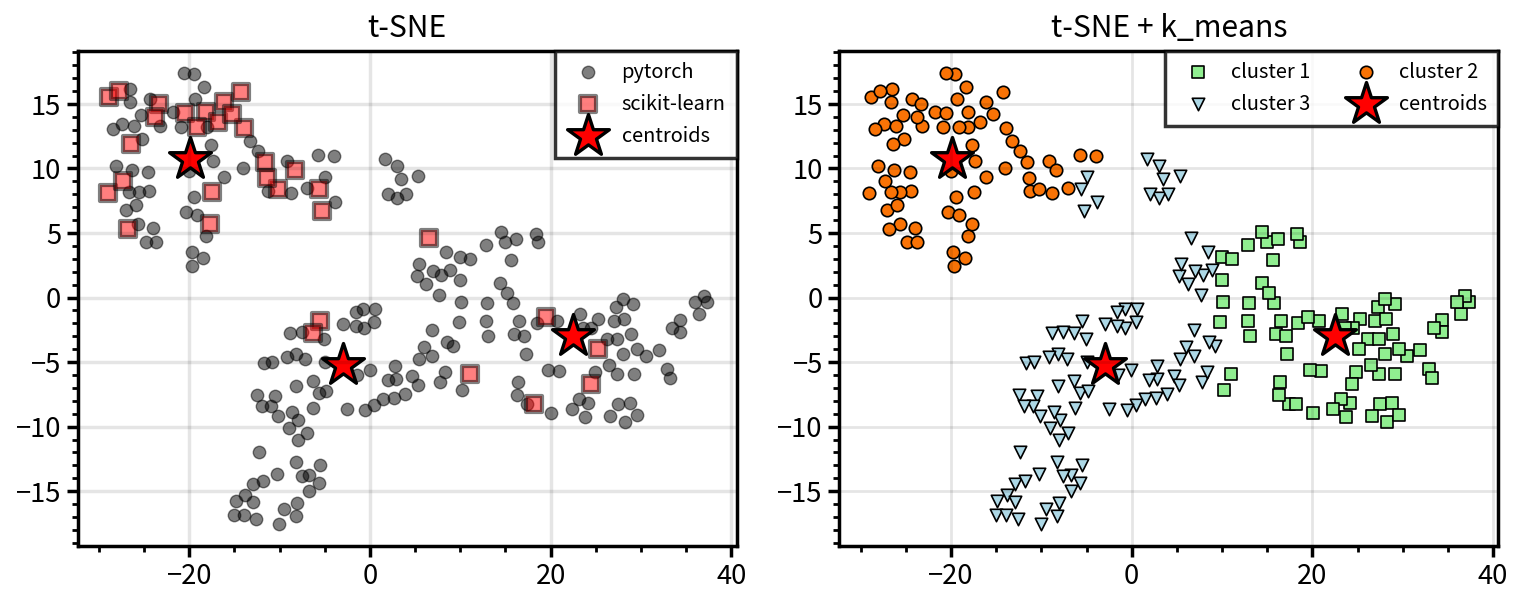

In [232]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=3.295,refaspect=1.331,share=False)
axs[0].scatter(X_plot[:-32,0],X_plot[:-32,1],s=20,linewidths=0.5,edgecolors='k',c='k',alpha=0.5,label='pytorch')
axs[0].scatter(X_plot[-32:,0],X_plot[-32:,1],s=30,linewidths=1.5,edgecolors='k',c='r',marker='s',alpha=0.5,label='scikit-learn')

axs[0].scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='r', edgecolor='black',
    label='centroids',linewidths=1.2)
axs[0].legend(scatterpoints=1,prop={'size':8},ncols=1)
# plot the 3 clusters
axs[1].scatter(X_plot[y_km == 0, 0], X_plot[y_km == 0, 1],s=20, c='lightgreen',marker='s', edgecolor='black',label='cluster 1')
axs[1].scatter(X_plot[y_km == 1, 0], X_plot[y_km == 1, 1],s=20, c='orange',marker='o', edgecolor='black',label='cluster 2')
axs[1].scatter(X_plot[y_km == 2, 0], X_plot[y_km == 2, 1],s=20, c='lightblue',marker='v', edgecolor='black',label='cluster 3')
# plot the centroids
axs[1].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],s=250, marker='*',c='r', edgecolor='black',label='centroids',linewidths=1.2)
axs[1].legend(scatterpoints=1,prop={'size':8},ncols=2)
axs[1].grid(lw=1)
axs[0].format(title='t-SNE')
axs[1].format(title='t-SNE + k_means')
plt.savefig('./pic/tsne_analysis.png',dpi=300)
plt.show()

In [283]:
allpd['TrueFalse0'] = [y_km[:-32] == 0][0]
allpd['TrueFalse1'] = [y_km[:-32] == 1][0]
allpd['TrueFalse2'] = [y_km[:-32] == 2][0]

In [285]:
allpd[allpd['TrueFalse0']==True][['u','v','w','theta']].mean()

u         -0.144874
v          0.615149
w       -165.931118
theta      0.010857
dtype: float64

In [284]:
allpd[allpd['TrueFalse1']==True][['u','v','w','theta']].mean()

u         0.447200
v         0.731931
w       -27.363415
theta     0.575293
dtype: float64

In [286]:
allpd[allpd['TrueFalse2']==True][['u','v','w','theta']].mean()

u         0.269698
v         0.733762
w       -43.003008
theta     0.466241
dtype: float64

In [287]:
def flatten(l):
    return [item for sublist in l for item in sublist]
allmodels_f = flatten(allmodels)
allmodels_f2 = [i for (i, v) in zip(allmodels_f, [y_km[:-32] == 2][0]) if v]#allmodels_f[[y_km[:-32] == 1][0]]

### Look at predictions

In [176]:
def give_pred(pcastore=None,model=None,splitnum=30,tensor_topred=None):
    bbbbbb_th = np.dot(model(tensor_topred).detach().numpy()[:,26+18+48:26+18+48+14],pcastore['theta'].components_[:14])
    bbbbbb_w = np.dot(model(tensor_topred).detach().numpy()[:,26+18:26+18+48],pcastore['w'].components_[:48])
    bbbbbb_v = np.dot(model(tensor_topred).detach().numpy()[:,26:26+18],pcastore['v'].components_[:18])
    bbbbbb_u = np.dot(model(tensor_topred).detach().numpy()[:,:26],pcastore['u'].components_[:26])
    return {'u':bbbbbb_u,'v':bbbbbb_v,'w':bbbbbb_w,'theta':bbbbbb_th}

In [ ]:
give_pred(pcastore=None,model=None,splitnum=30,tensor_topred=None)

/tmp/ipykernel_440535/565967204.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


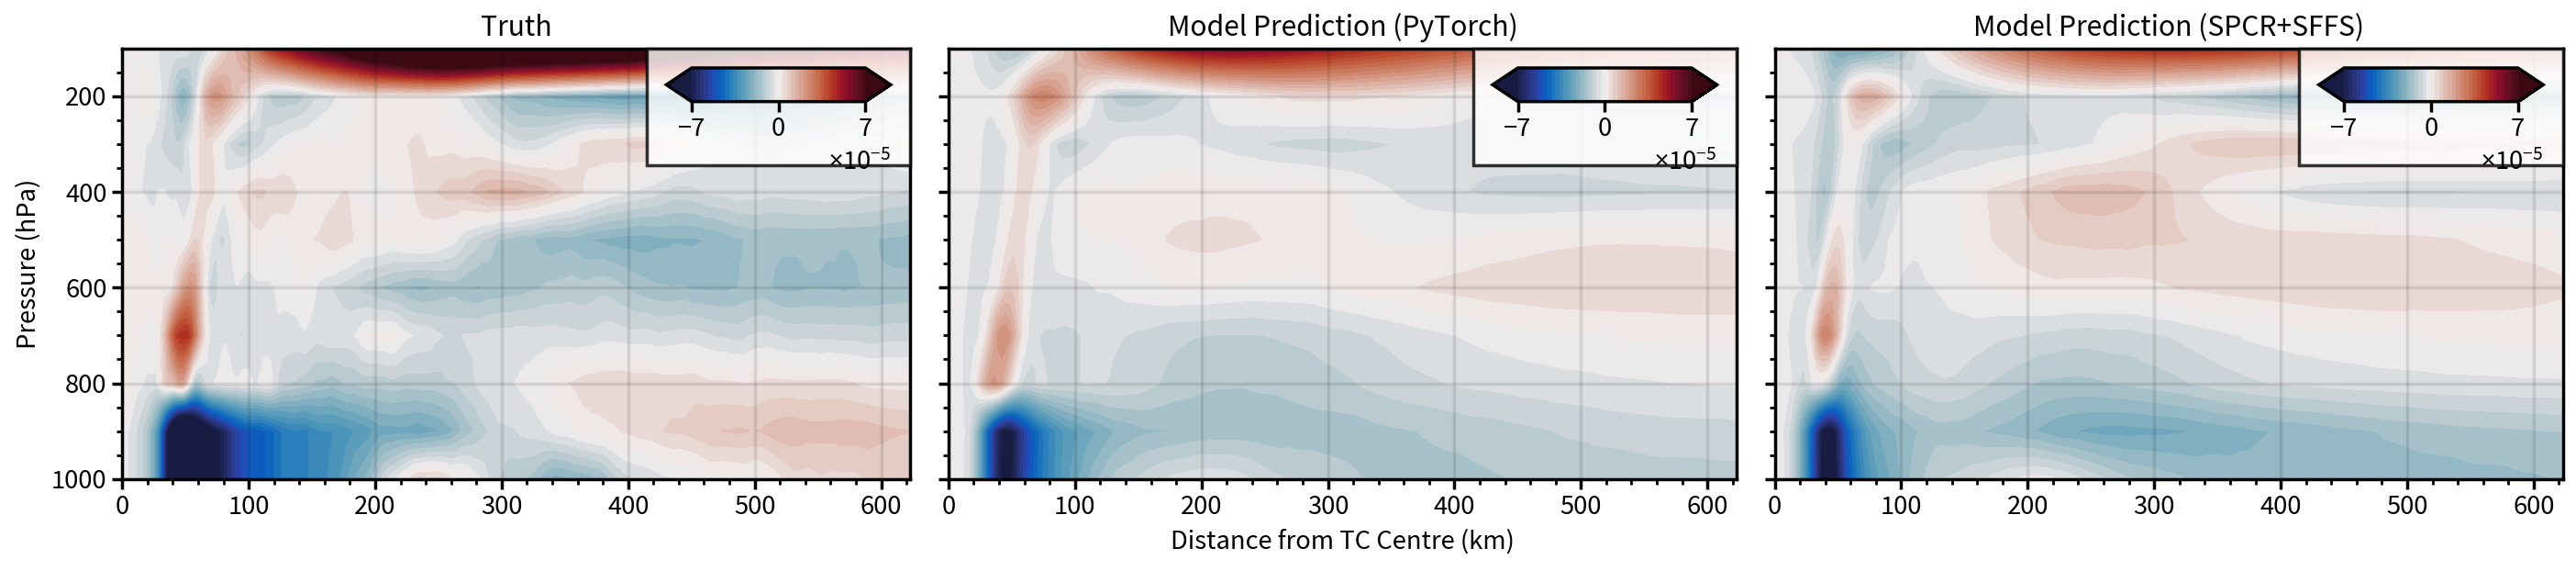

In [100]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['du'][40,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=7e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_u[40,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=7e-5)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (PyTorch)')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_u[40,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=7e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
#plt.savefig('./pic/du_prediction_train_all_60.png',dpi=300)
plt.show()

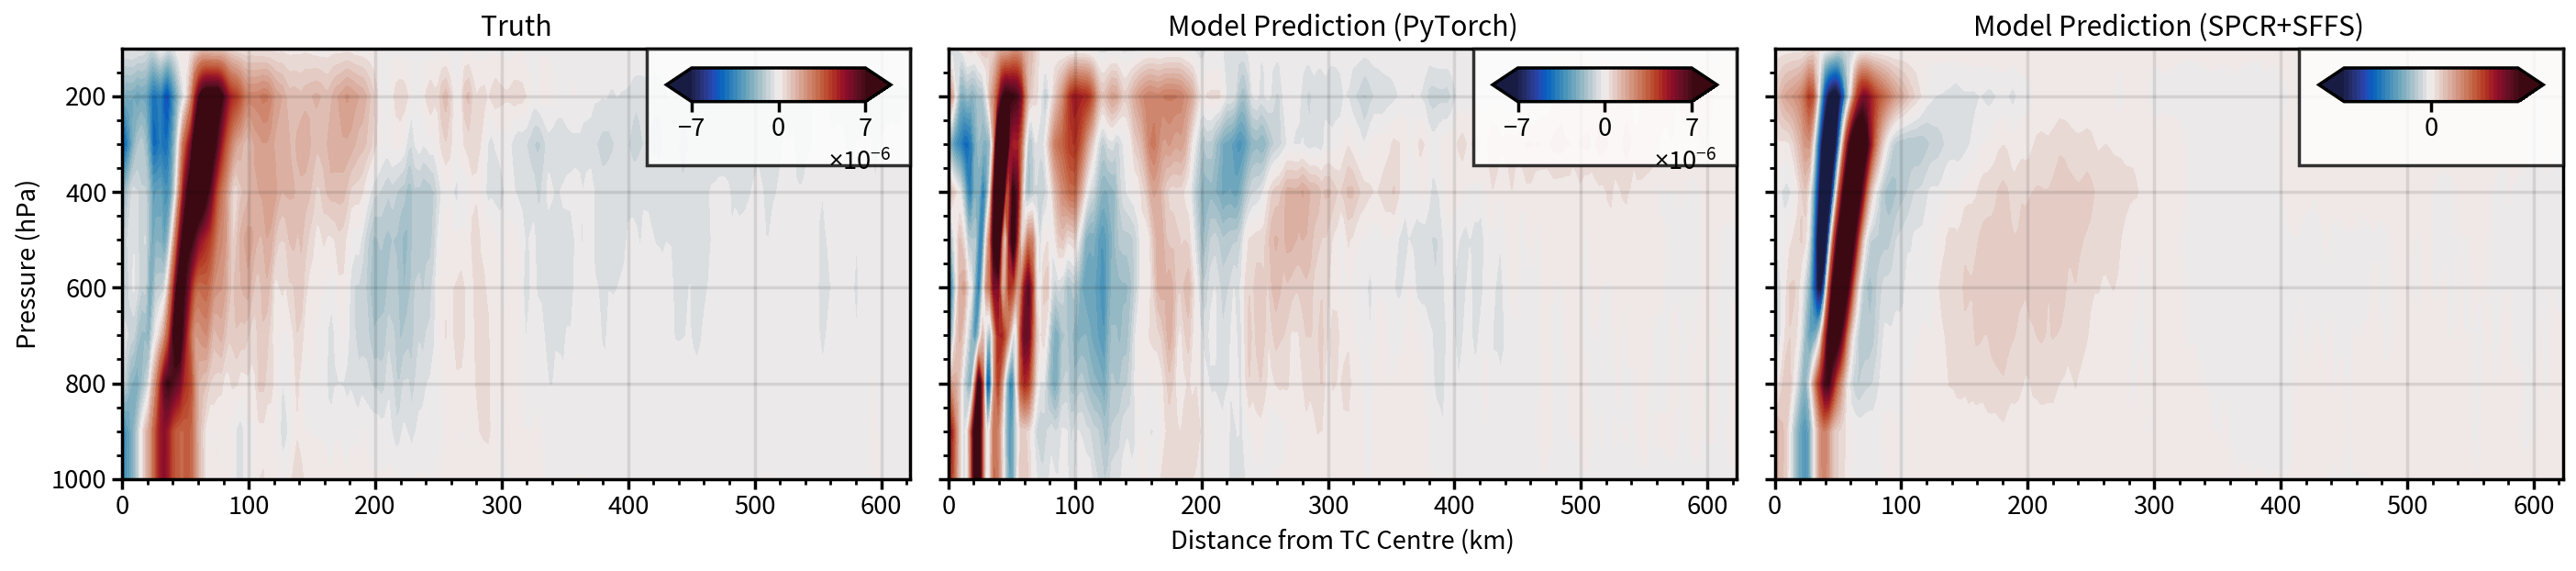

In [54]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['dw'][70,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=7e-6)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_w[70,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=7e-6)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (PyTorch)')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_w[70,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=7e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
plt.savefig('./pic/dw_prediction_train_lwswuw_withorig_70.png',dpi=300)
plt.show()

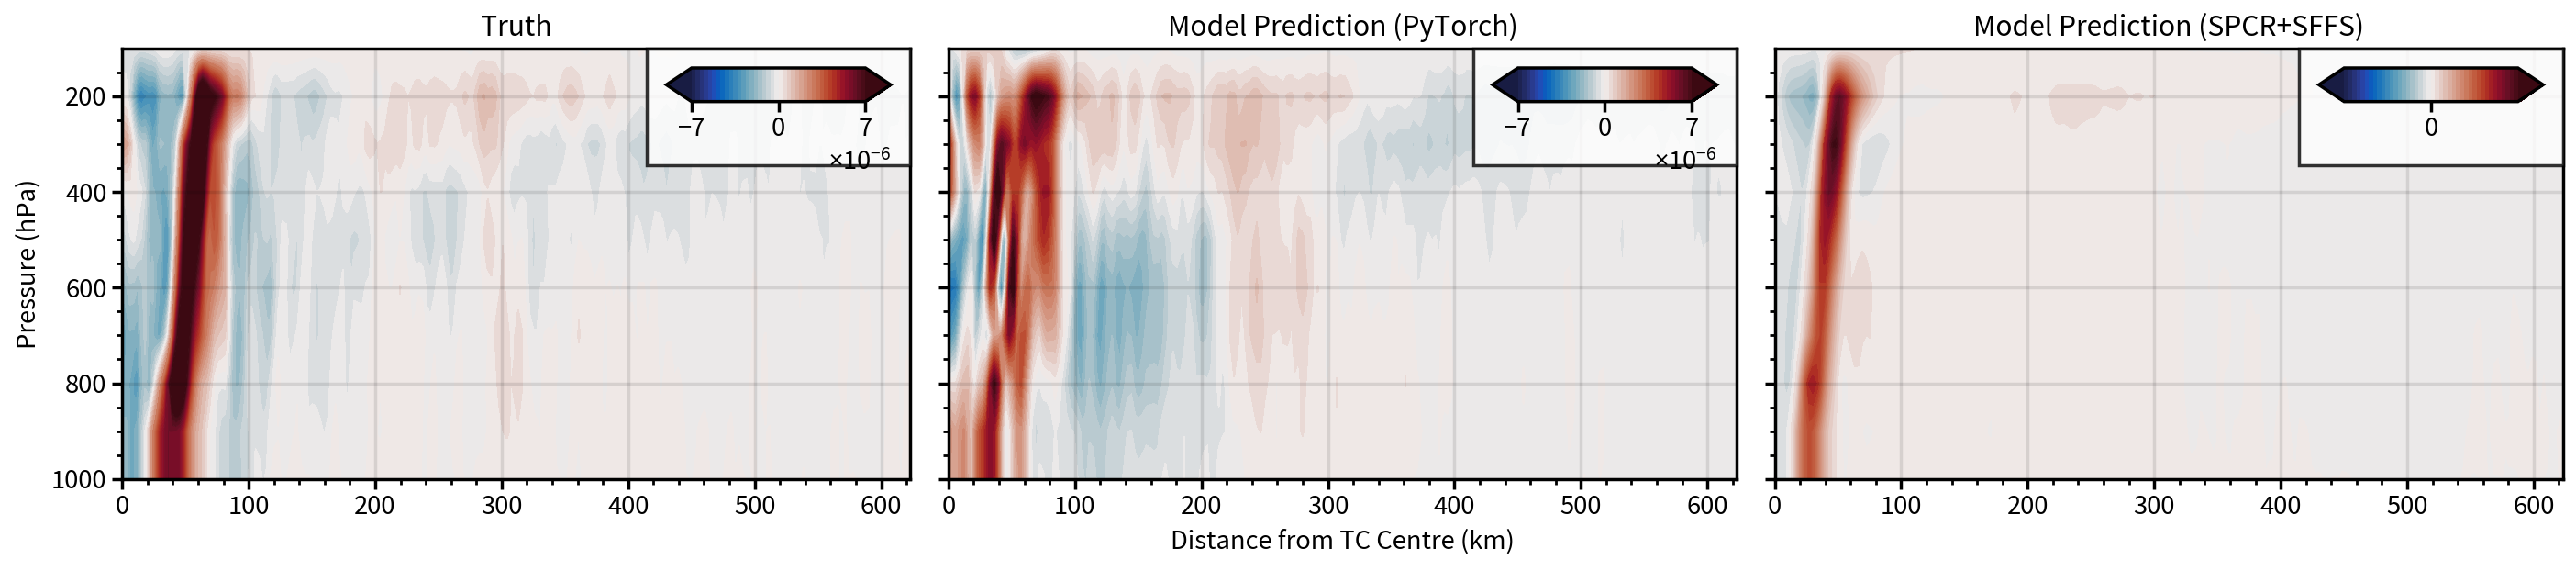

In [102]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['dw'][78,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=7e-6)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_w[80,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=7e-6)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (PyTorch)')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_w[80,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-6,7e-6,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=7e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
#plt.savefig('./pic/dw_prediction_train_all_withorig_50.png',dpi=300)
plt.show()

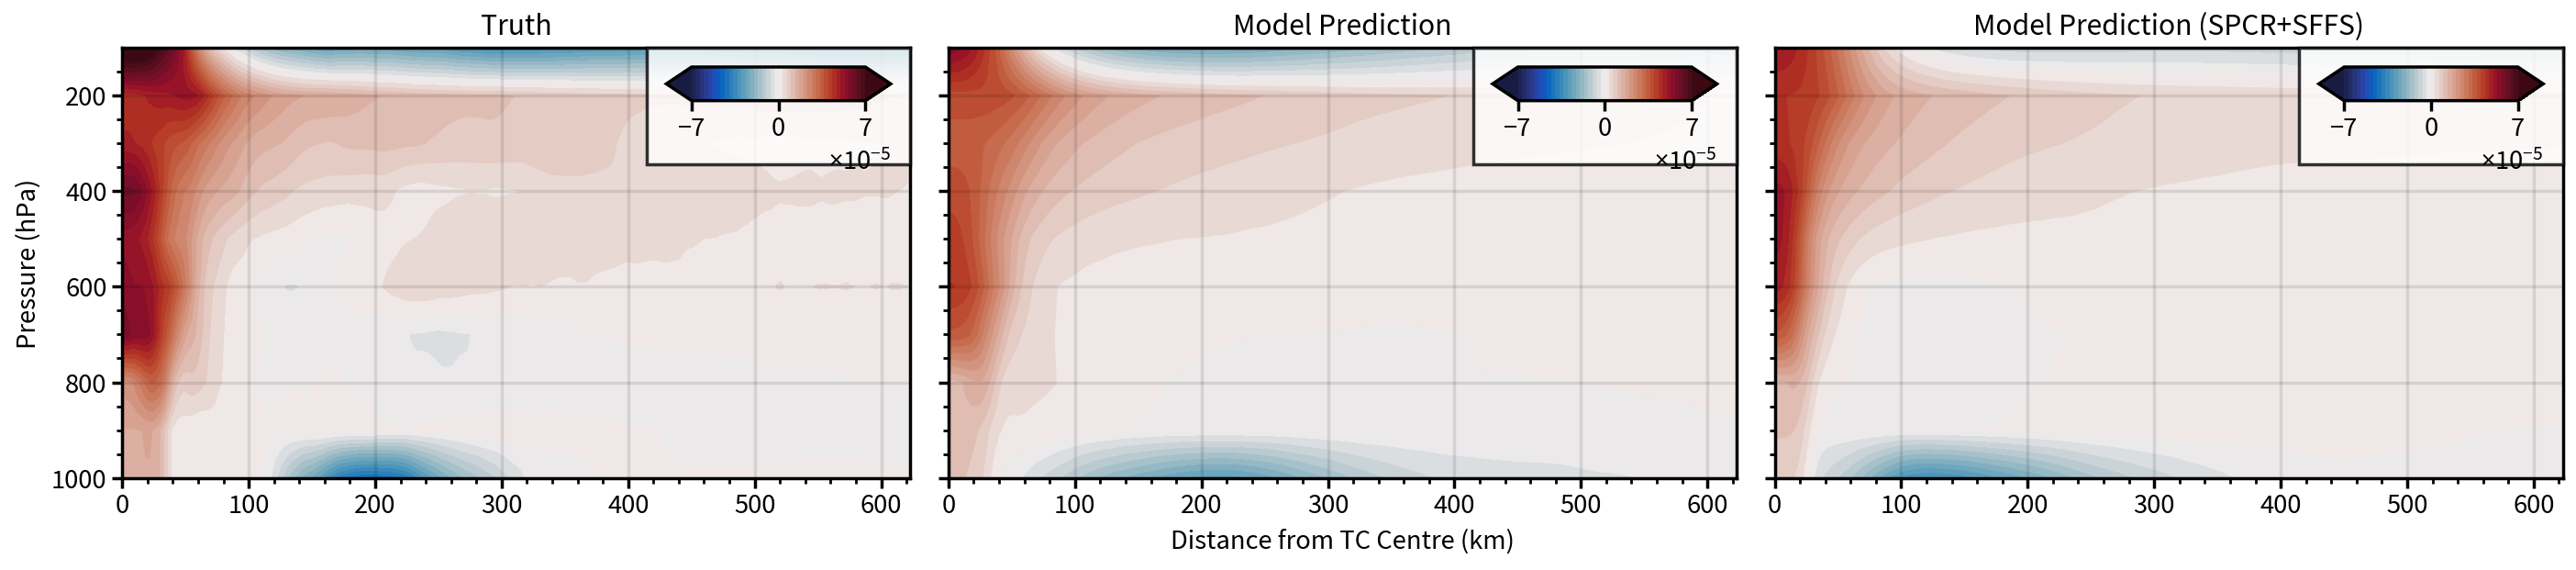

In [96]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['dth'][20,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=7e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_th[20,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=7e-5)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_th[20,...].reshape(10,208),cmap='balance',levels=np.linspace(-7e-5,7e-5,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=7e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
#plt.savefig('./pic/dth_prediction_train_all_withorig_0.png',dpi=300)
plt.show()

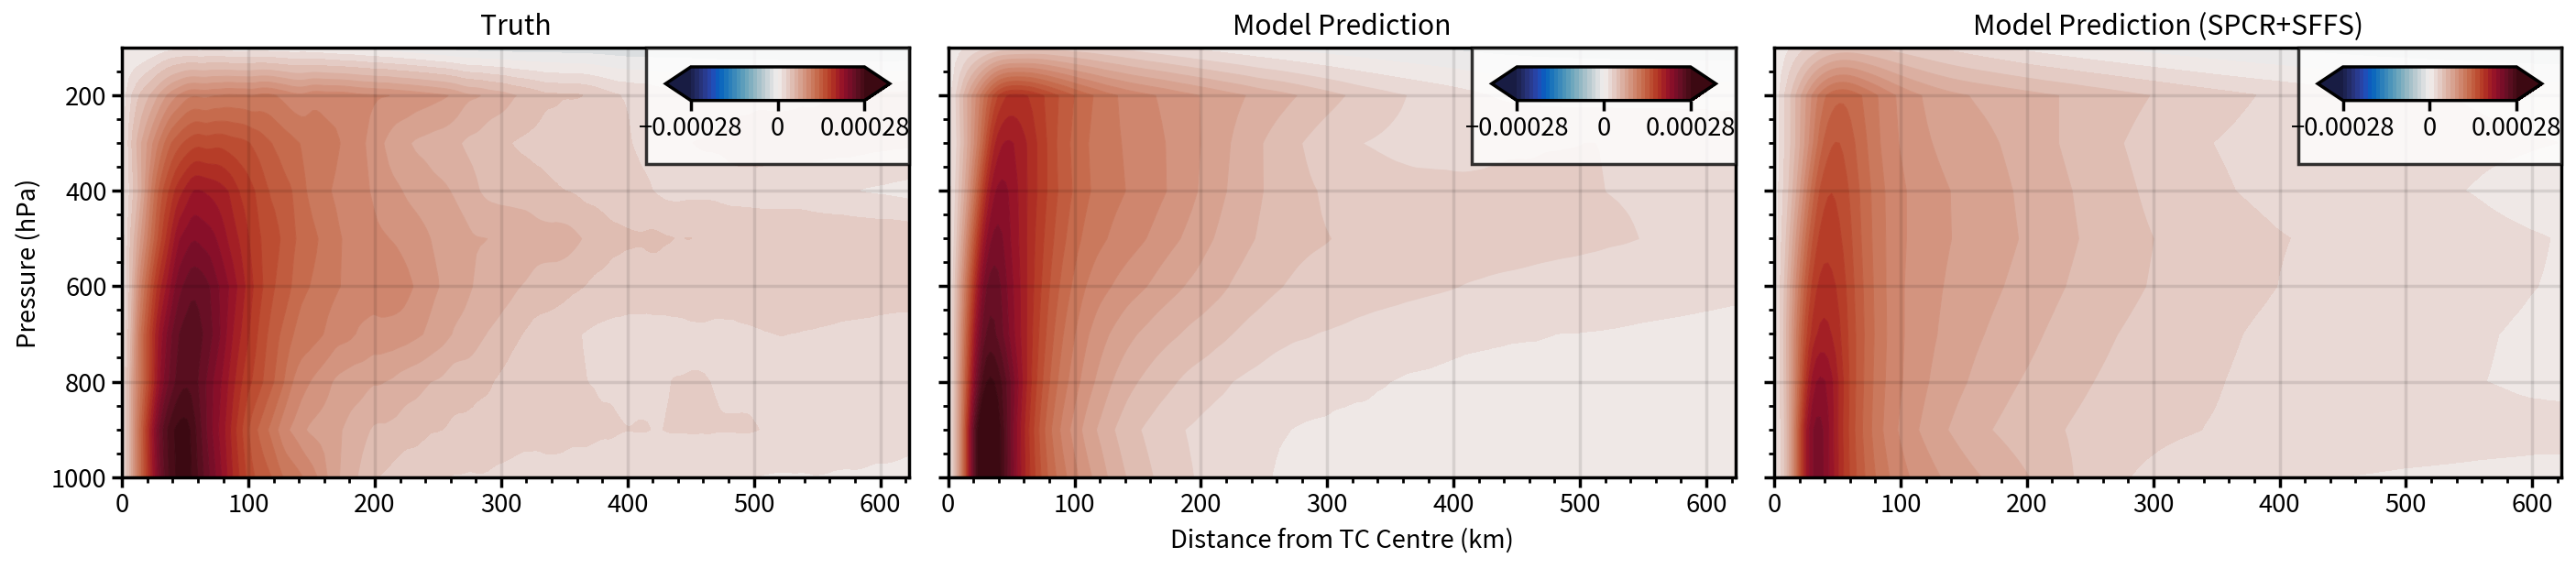

In [95]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),yTRUTH['test'][0]['dv'][0,...].reshape(10,208),cmap='balance',levels=np.linspace(-28e-5,28e-5,43),extend='both')
axs[0].colorbar(pcw,loc='ur',ticks=28e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),bbbbbb_v[0,...].reshape(10,208),cmap='balance',levels=np.linspace(-28e-5,28e-5,43),extend='both')
axs[1].colorbar(pcw,loc='ur',ticks=28e-5)
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),orig_v[2,...].reshape(10,208),cmap='balance',levels=np.linspace(-28e-5,28e-5,43),extend='both')
axs[2].colorbar(pcw,loc='ur',ticks=28e-5)
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (SPCR+SFFS)')
#plt.savefig('./pic/dv_prediction_train_all_withorig_0.png',dpi=300)
plt.show()

### Optimal Structures

In [21]:
def flatten(l):
    return [item for sublist in l for item in sublist]
def normalize(array):
    return (array-np.nanmean(array))/np.nanstd(array)

allmodels_f = flatten(test_allmdls)
choosemodel = list(test_allpds['v2'].sort_values(by=['mean'], ascending=False).index)[0:5]
allmodels_f2 = [allmodels_f[objindx] for objindx in choosemodel]

allparams,allnames = [],[]
for i in range(len(allmodels_f2)):
    params,names = [],[]
    for name, param in allmodels_f2[i][0].named_parameters():
        if ".weight" not in name:
            continue
        else:
            params.append(param)
            names.append(name)
        #if (name=='dense8.weight') or (name=='dense7.weight'):
        #    params.append(param)
        #else:
        #    continue
    allparams.append(params)
    allnames.append(names)

In [22]:
optU = [np.squeeze(np.dot(allparam[0].data.numpy(),pcastore['lw'].components_[:52,:])).reshape(10,208) for allparam in allparams]
optV = [np.squeeze(np.dot(allparam[1].data.numpy(),pcastore['lw'].components_[:36,:])).reshape(10,208) for allparam in allparams]
optW = [np.squeeze(np.dot(allparam[2].data.numpy(),pcastore['lw'].components_[:60,:])).reshape(10,208) for allparam in allparams]
#optQV = [np.squeeze(np.dot(allparam[4].data.numpy(),pcastore['rh'].components_[:18,:])).reshape(10,208) for allparam in allparams]
optHDIA = [np.squeeze(np.dot(allparam[4].data.numpy(),pcastore['hdia'].components_[:18,:])).reshape(10,208) for allparam in allparams]
optLW = [np.squeeze(np.dot(allparam[5].data.numpy(),pcastore['lw'].components_[:30,:])).reshape(10,208) for allparam in allparams]
optSW = [np.squeeze(np.dot(allparam[6].data.numpy(),pcastore['sw'].components_[:30,:])).reshape(10,208) for allparam in allparams]

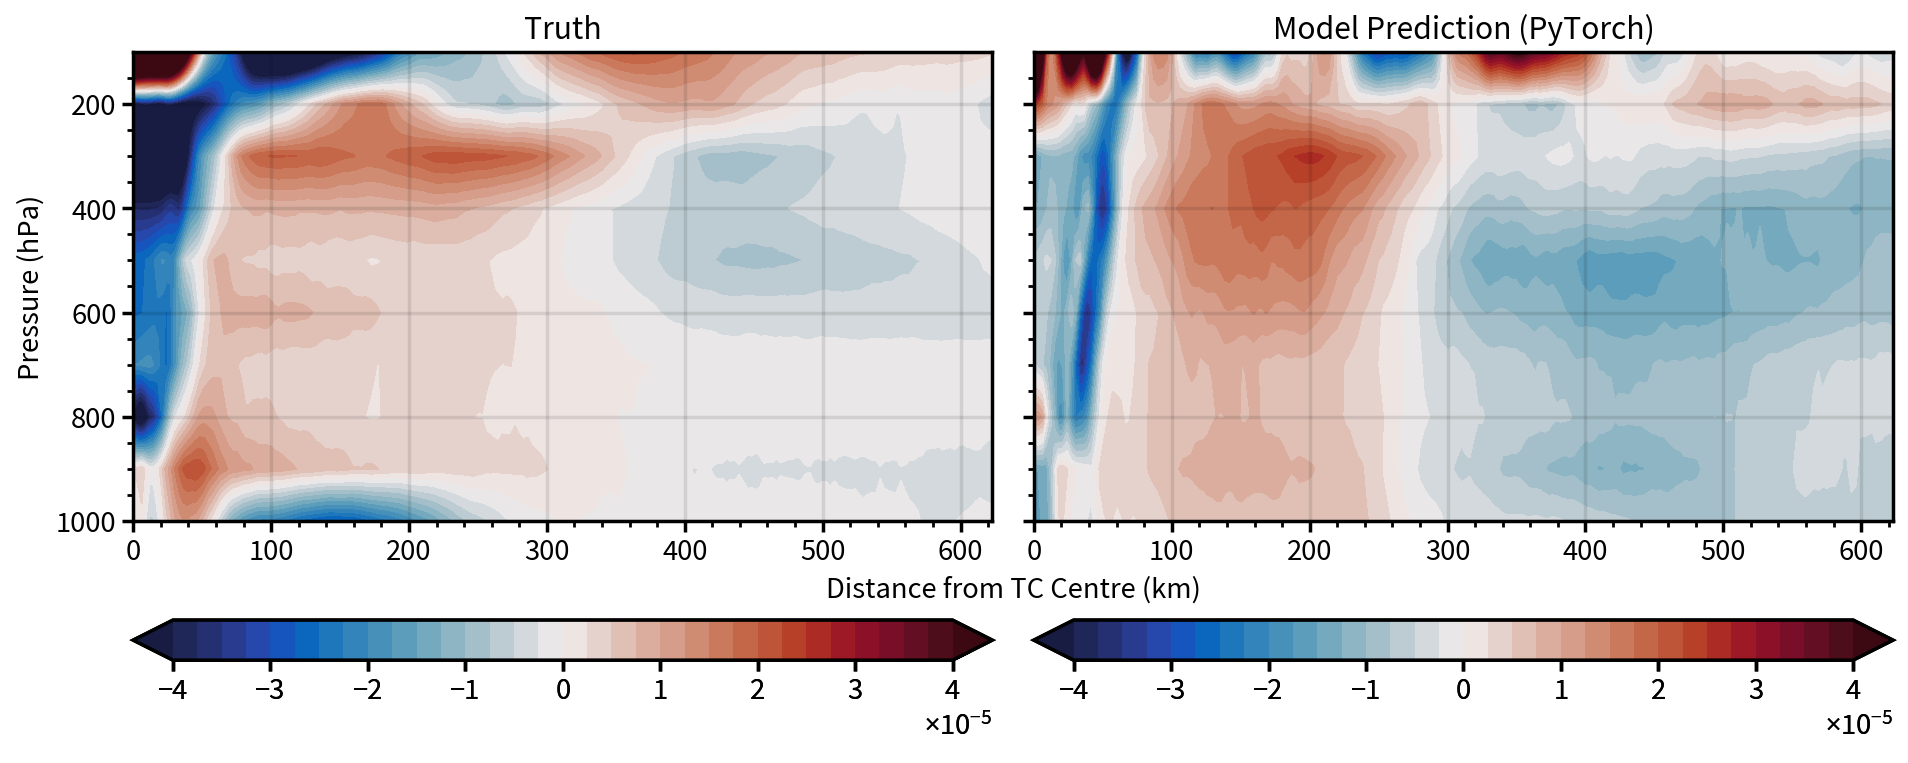

In [161]:
fig,axs = plot.subplots(ncols=2,nrows=1,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),np.squeeze(np.dot(params[0].data.numpy(),pcastore['lw'].components_[:30,:])).reshape(10,208),levels=np.linspace(-0.4e-4,0.4e-4,33),cmap='balance',extend='both')
axs[0].colorbar(pcw,loc='bottom')#,ticks=7e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Truth')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),np.squeeze(np.dot(params[1].data.numpy(),pcastore['sw'].components_[:30,:])).reshape(10,208),levels=np.linspace(-0.4e-4,0.4e-4,33),cmap='balance',extend='both')
axs[1].colorbar(pcw,loc='bottom')
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Model Prediction (PyTorch)')
#plt.savefig('./pic/du_prediction_train_all_60.png',dpi=300)
plt.show()

/tmp/ipykernel_2172698/90861964.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


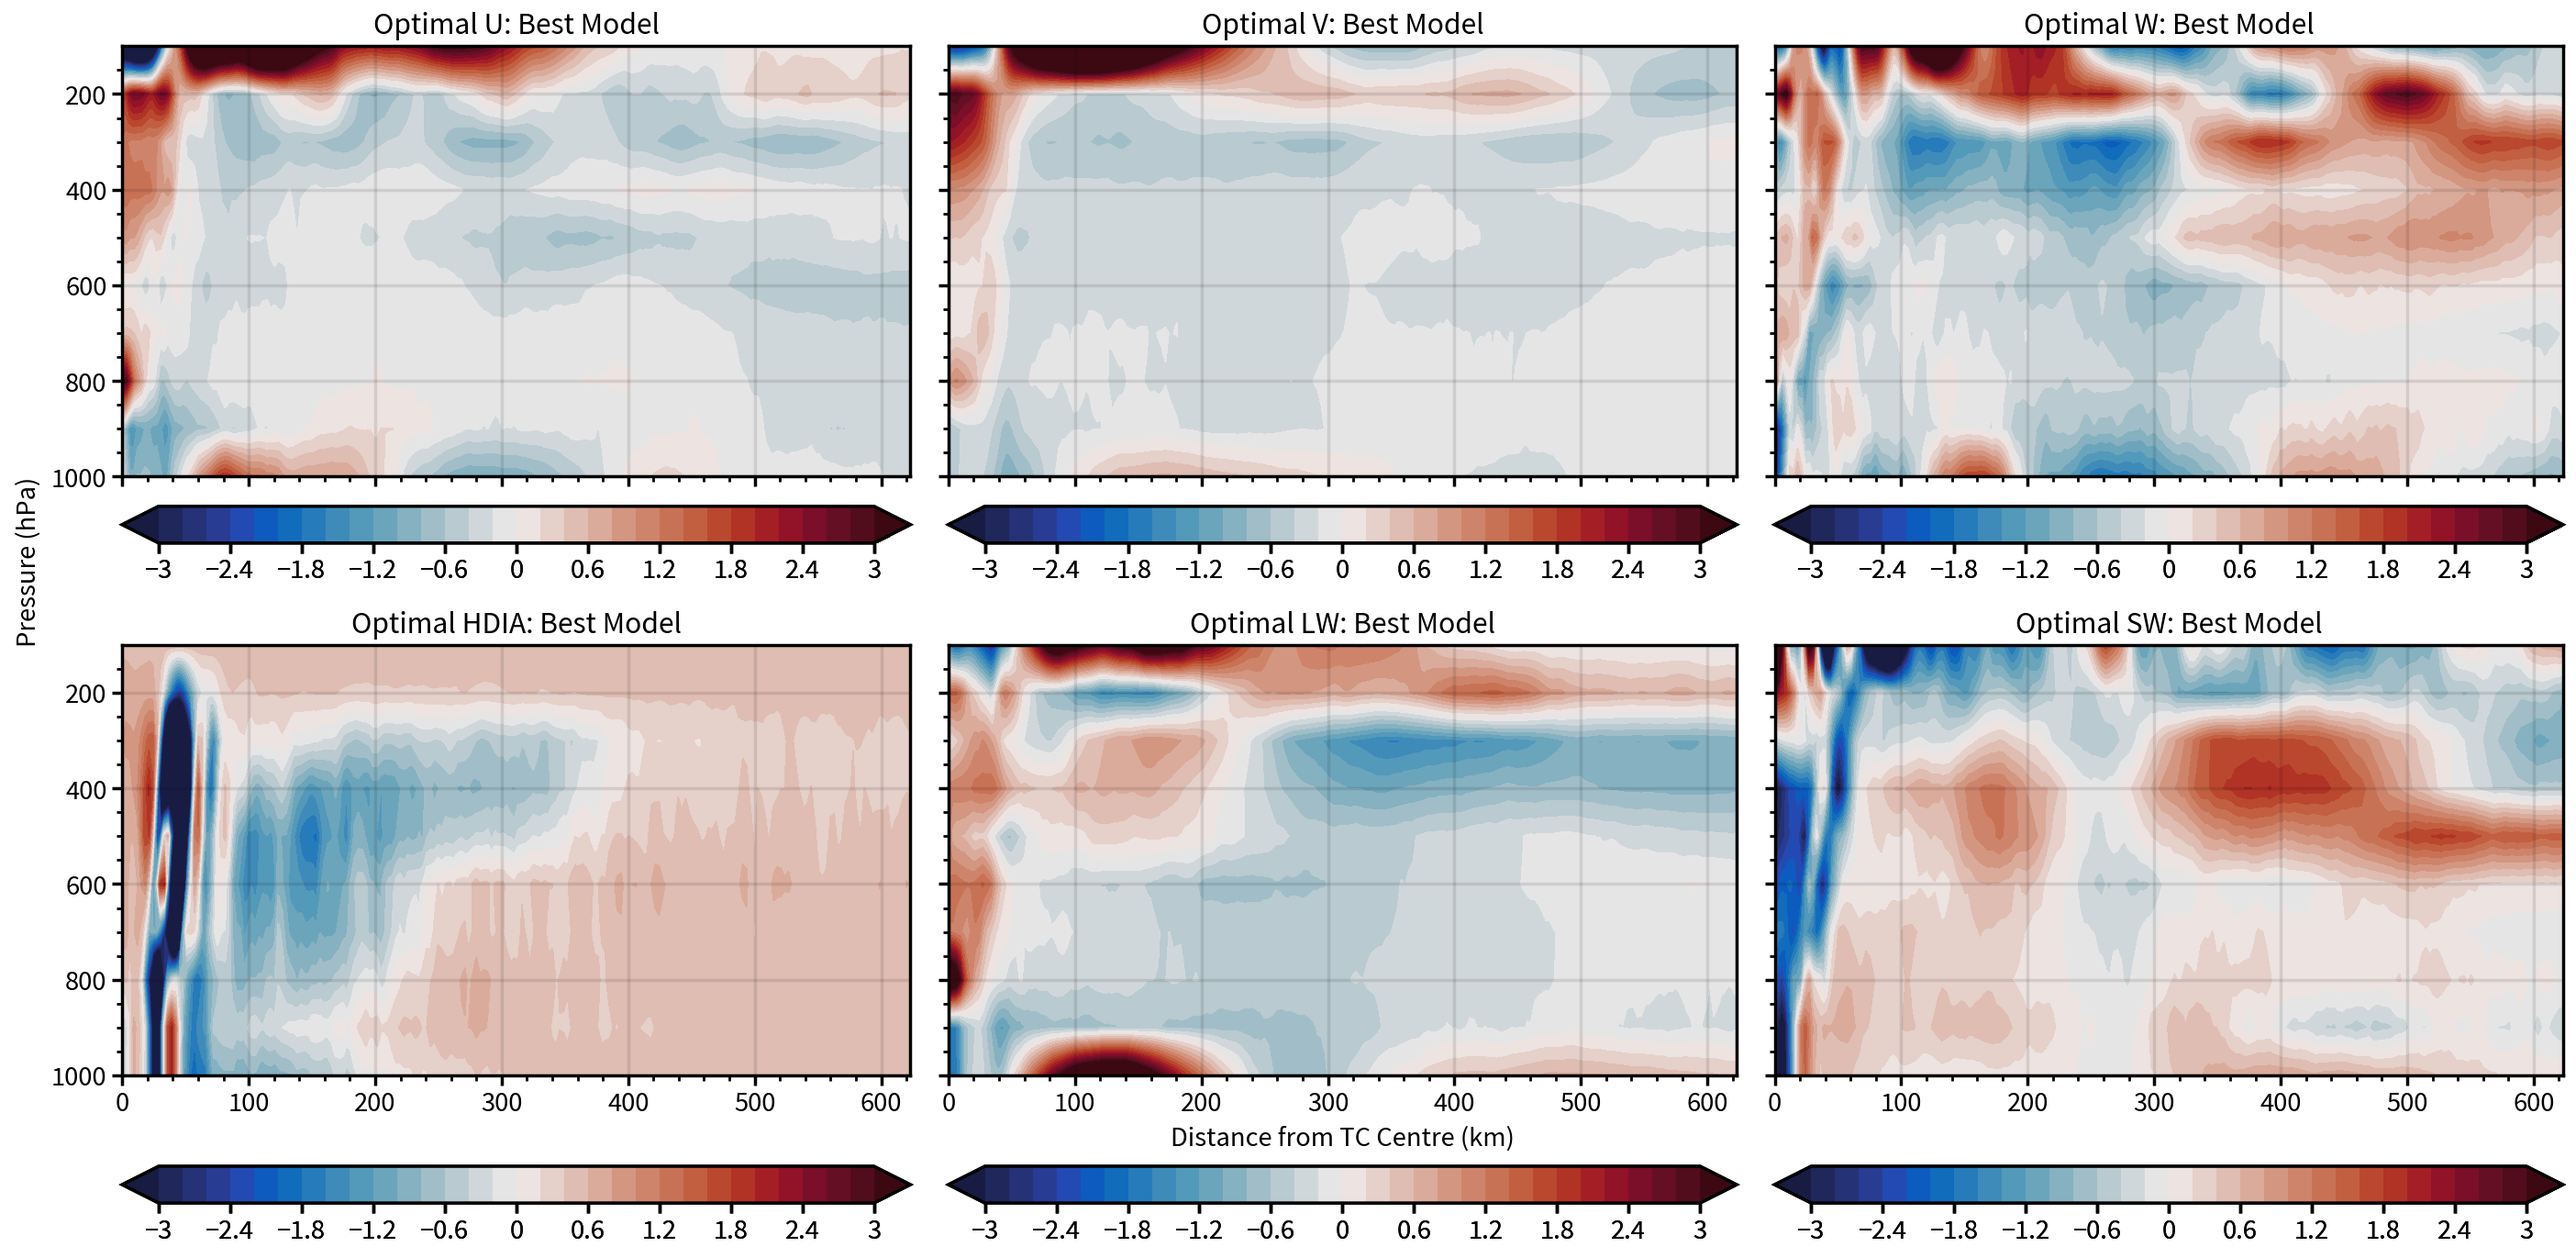

In [24]:
plot.rc.metacolor = 'k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'w'

indx=1
fig,axs = plot.subplots(ncols=3,nrows=2,axwidth=4.295,refaspect=1.831)
pcw = axs[0].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize((np.asarray(optU[indx]))),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[0].colorbar(pcw,loc='bottom')#,ticks=7e-5)
axs[0].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal U: Best Model')

pcw = axs[1].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize((np.asarray(optV[indx]))),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[1].colorbar(pcw,loc='bottom')
axs[1].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal V: Best Model')

pcw = axs[2].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize((np.asarray(optW[indx]))),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[2].colorbar(pcw,loc='bottom')
axs[2].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal W: Best Model')

pcw = axs[3].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize((np.asarray(optHDIA[indx]))),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[3].colorbar(pcw,loc='bottom')
axs[3].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal HDIA: Best Model')

pcw = axs[4].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize(np.asarray(optLW[indx])),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[4].colorbar(pcw,loc='bottom')#,ticks=7e-5)
axs[4].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal LW: Best Model')

pcw = axs[5].contourf(np.linspace(0,208*3-1,208),np.linspace(1000,100,10),normalize(np.asarray(optSW[indx])),levels=np.linspace(-3,3,31),cmap='balance',extend='both')
axs[5].colorbar(pcw,loc='bottom')
axs[5].format(xlabel=r'Distance from TC Centre (km)',ylabel='Pressure (hPa)',title='Optimal SW: Best Model')
plt.savefig('./pic/proposal/optimall.png',dpi=400)
plt.show()

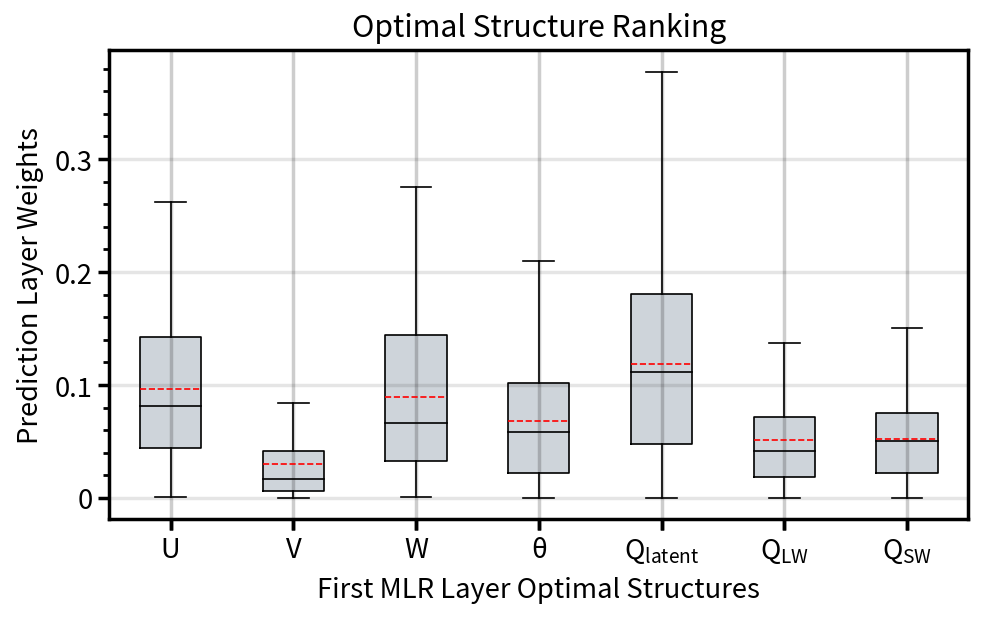

In [70]:
import seaborn as sns
indx=
ansss = [np.abs(allparams[indx][-1].data.numpy()[:,i]) for i in range(7)]
#anssss = [np.abs(weight*np.mean(xs)) for weight,xs in zip(ansss,[normalize(timeseries_u[0]),normalize(timeseries_v[0]),
#                                                                   normalize(timeseries_w[0]),normalize(timeseries_theta[0]),normalize(timeseries_hdia[0]),normalize(timeseries_lw[0]),normalize(timeseries_sw[0])])]
dataFI_haiyan = pd.DataFrame(np.asarray(ansss).transpose(),columns=['U','V','W',r'$\theta$',r'$Q_{latent}$',r'$Q_{LW}$',r'$Q_{SW}$'])

fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)#wspace=(0, 0, 0),height_ratios=[1.75, 1],sharey=0)
axs.boxplot(dataFI_haiyan, means=True, marker='x', meancolor='r', fillcolor='gray4', orientation='vertical',showfliers=False)
axs.format(ylabel=r'Prediction Layer Weights',xlabel='First MLR Layer Optimal Structures',title=r'Optimal Structure Ranking')#xlim=[0,0.0002*1.5e4])#ylim=[0,20])
plt.savefig('./pic/1114/optim_structures_bestmodel2_weights.png',dpi=400)
plt.show()
#pd.DataFrame(ansss).T.plot.box(ax=ax)

In [25]:
def normalize_timeseries(timeseries=None):
    #assert timeseries['u'].shape[-1]==26,"var shape error"
    obj = (timeseries-np.nanmean(timeseries,axis=0))/np.nanstd(timeseries,axis=0)
    return obj

In [27]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/TCG_Rad_keras/'
#folderpath2='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/testML/output/haiyan/processed/intermediate/'
haiyan_data = read_and_proc.depickle(folderpath+'flatarrays2D.pkg')
timeseries_v = [np.dot(allparam[1].data.numpy(),normalize_timeseries(pcastore['v'].transform(haiyan_data['v'])[:,:36].T)) for allparam in allparams]
timeseries_u = [np.dot(allparam[0].data.numpy(),normalize_timeseries(pcastore['u'].transform(haiyan_data['u'])[:,:52].T)) for allparam in allparams]
timeseries_w = [np.dot(allparam[2].data.numpy(),normalize_timeseries(pcastore['w'].transform(haiyan_data['w'])[:,:60].T)) for allparam in allparams]
timeseries_theta = [np.dot(allparam[3].data.numpy(),normalize_timeseries(pcastore['theta'].transform(haiyan_data['theta'])[:,:28].T)) for allparam in allparams]
timeseries_lw = [np.dot(allparam[5].data.numpy(),normalize_timeseries(pcastore['lw'].transform(haiyan_data['lw'])[:,:30].T)) for allparam in allparams]
timeseries_sw = [np.dot(allparam[6].data.numpy(),normalize_timeseries(pcastore['sw'].transform(haiyan_data['sw'])[:,:30].T)) for allparam in allparams]
timeseries_hdia = [np.dot(allparam[4].data.numpy(),normalize_timeseries(pcastore['hdia'].transform(haiyan_data['hdia'])[:,:18].T)) for allparam in allparams]

In [28]:
def _back_to_exp(timeseries=None,divider=None):
    try:
        printout = [timeseries[0:divider[0],:]]
        for i in range(1,19):
            printout.append(timeseries[divider[i-1]:divider[i],:])
        printout.append(timeseries[divider[-2]:,:])
    except:
        printout = [timeseries[0:divider[0]]]
        for i in range(1,19):
            printout.append(timeseries[divider[i-1]:divider[i]])
        printout.append(timeseries[divider[-2]:])        
    return printout

In [29]:
indx=2
testlw,testsw,testhdia = _back_to_exp(np.squeeze(timeseries_lw[indx]),divider),_back_to_exp(np.squeeze(timeseries_sw[indx]),divider),_back_to_exp(np.squeeze(timeseries_hdia[indx]),divider)

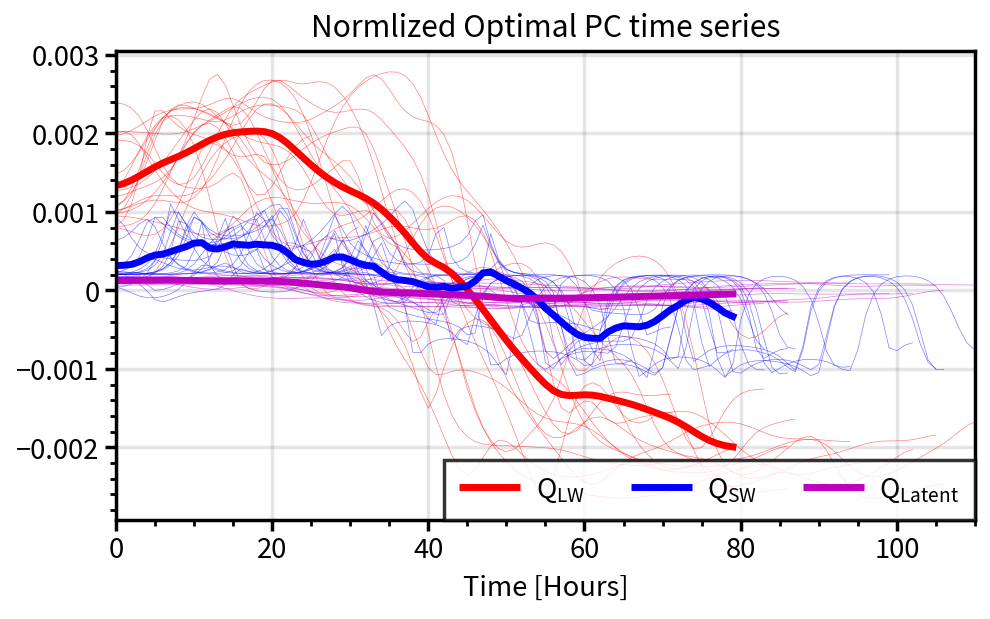

In [31]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
for obj in testlw:
    axs.plot(obj,color='r',lw=0.25,alpha=0.5)
for obj in testsw:
    axs.plot(obj,color='b',lw=0.25,alpha=0.5)
for obj in testhdia:
    axs.plot(obj,color='m',lw=0.25,alpha=0.5)
axs.plot(np.mean(np.asarray([obj[:80] for obj in testlw if int(obj.shape[0])>80]),axis=0),color='r',lw=2.5,label=r'Q$_{LW}$')
axs.plot(np.mean(np.asarray([obj[:80] for obj in testsw if int(obj.shape[0])>80]),axis=0),color='b',lw=2.5,label=r'Q$_{SW}$')
axs.plot(np.mean(np.asarray([obj[:80] for obj in testhdia if int(obj.shape[0])>80]),axis=0),color='m',lw=2.5,label=r'Q$_{Latent}$')
axs.legend(loc='lr')
axs.format(xlabel='Time [Hours]',title='Normlized Optimal PC time series',)#ylim=[-0.0005,0.0005])
plt.savefig('./pic/proposal/optim_structures_bestmodel2_timeseries_divided.png',dpi=400)
plt.show()